# Trabajo Practico Integrador - Análisis de Datos

**Grupo:** Mariano Campos, Leandro Lepera, Ojeda Juan Cruz  
**Cohorte:** 19Co2024 - CEIA  
**Materia:** Análisis de Datos  
**Tema asignado:** Meteorología en Argentina


## 1. Motivación

Para este trabajo final, se nos asignó el dataset relacionado con la **meteorología en Argentina**, con el objetivo de aplicar herramientas de análisis de datos para comprender mejor fenómenos climatológicos recientes y su comparación con patrones históricos.

Contamos con dos fuentes de información:
- Un registro **diario** de temperaturas del **último año**.
- Estadísticas **mensuales promedio** de los **últimos 30 años** (1991–2020).

## 2. Contexto y descripción del dataset

Para este trabajo se utilizan conjuntos de datos oficiales del **Servicio Meteorológico Nacional (SMN)** de Argentina, extraídos de su portal de datos abiertos.

### Dataset 1: Registro diario de temperaturas (último año)

- **Fuente:** Datos abiertos del SMN.
- **Contenido:** Registros **diarios** de temperaturas mínimas y máximas correspondientes a múltiples estaciones meteorológicas distribuidas en el país.
- **Variables principales:** Fecha, nombre de la estación, provincia, temperatura mínima, temperatura máxima.
- **Periodo:** Últimos 365 días (a partir de la fecha de descarga).
- **Formato original:** Texto plano delimitado por tabulaciones (`.txt`), una fila por día por estación.

### Dataset 2: Estadísticas normales (promedios 1991–2020)

- **Fuente:** Datos abiertos del SMN.
- **Contenido:** Promedios **mensuales** de variables meteorológicas calculados sobre un periodo de 30 años (1991 a 2020), utilizados como referencia climática.
- **Variables principales:** Estación, variable medida (ej. temperatura mínima, temperatura máxima), y valores mensuales de enero a diciembre.
- **Periodo:** Promedios 1991–2020.
- **Formato original:** Texto plano delimitado por tabulaciones (`.txt`), una fila por estación y por variable.

### Dataset 3: Ubicación geográfica de estaciones meteorológicas

- **Fuente:** Datos abiertos del SMN.
- **Contenido:** Información geográfica de las estaciones meteorológicas utilizadas en los otros dos datasets.
- **Variables principales:** Nombre de estación, provincia, latitud, longitud, altitud, código OACI.
- **Uso en este trabajo:** Se utilizó para incorporar coordenadas geográficas a las estaciones, lo que permitió realizar análisis regionales y visualizaciones espaciales.
- **Archivo:** `estaciones_smn.txt`

### Consideraciones

Todos los archivos fueron verificados con los docentes como los correspondientes al tema asignado. Durante el análisis, se realizaron transformaciones para adecuar los formatos (por ejemplo, convertir el segundo dataset a formato largo) y unificar criterios para permitir la comparación entre las fuentes. Además, el uso del tercer dataset permitió agrupar estaciones por región geográfica y enriquecer el análisis climático.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
#from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import json

## 2.1 Exploración y comprensión de los datos

En esta sección se describe la estructura general de los datasets, visualizando las primeras filas, tipos de datos y cantidad de registros. También se realiza una primera evaluación de valores faltantes y posibles inconsistencias.

---

### Dataset: registro_temperatura365d_smn

In [12]:
df_ly_raw = pd.read_fwf("Datos/registro_temperatura365d_smn.txt", skiprows=1, encoding="latin1") #La primera linea esta en blanco (skiprows=1)
print(f"Cantidad de filas: {df_ly_raw.shape[0]}")
print(f"Cantidad de columnas: {df_ly_raw.shape[1]}")

df_ly_raw.head()

Cantidad de filas: 42916
Cantidad de columnas: 4


,FECHA,TMAX,TMIN,NOMBRE
0,--------,-----,-----,----------------------------------------
1,30032025,28.9,21.4,AEROPARQUE AERO
2,30032025,23.0,13.7,AZUL AERO
3,30032025,22.6,14.6,BAHIA BLANCA AERO
4,30032025,12.6,4.4,BARILOCHE AERO


In [13]:
print('Nombres y tipos de columnas')
df_ly_raw.dtypes

Nombres y tipos de columnas


FECHA     object
TMAX      object
TMIN      object
NOMBRE    object
dtype: object

In [14]:
print('Cantidad de valores nulos por columna')
df_ly_raw.isnull().sum()

Cantidad de valores nulos por columna


FECHA        0
TMAX      4525
TMIN       620
NOMBRE       0
dtype: int64

Visualizando los valores nulos


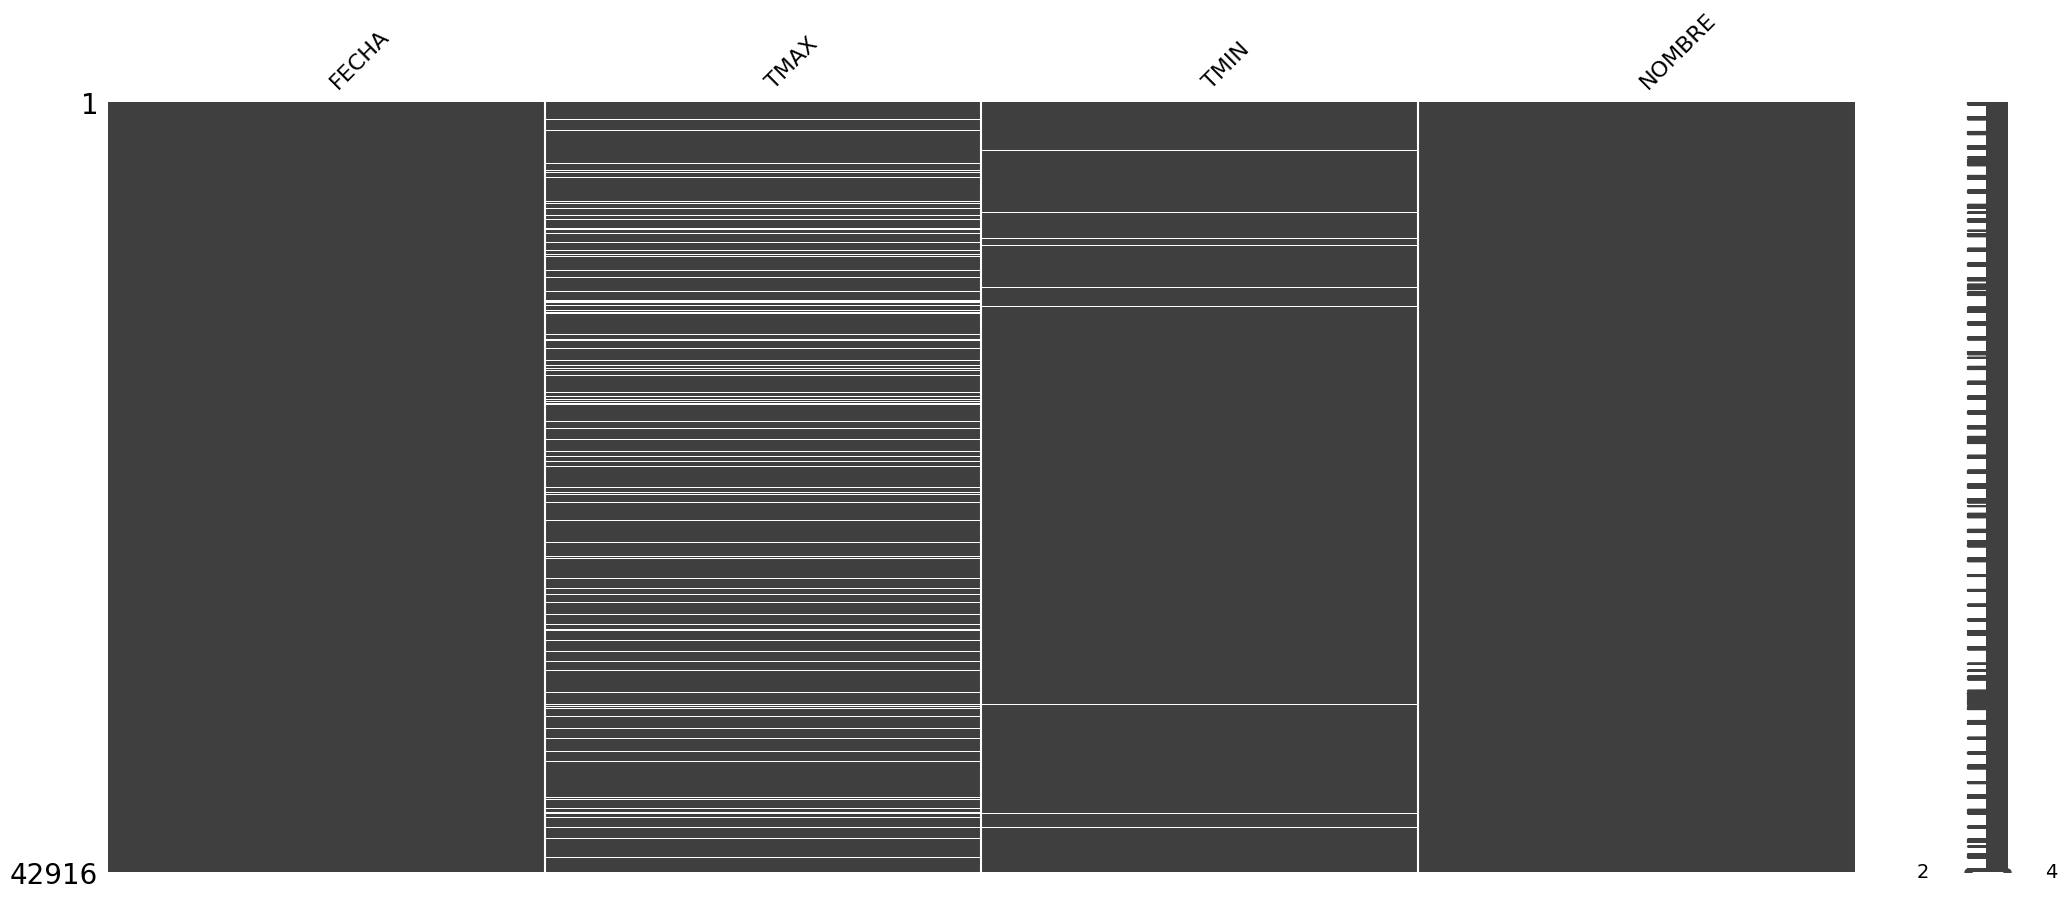

In [15]:
print('Visualizando los valores nulos')
msno.matrix(df_ly_raw);

In [16]:
print("Estaciones únicas:")
print(df_ly_raw['NOMBRE'].nunique())

Estaciones únicas:
119


A partir de la inspección inicial del dataset `df_ly_raw`, se observa lo siguiente:

- El dataset contiene una gran cantidad de filas (una por estación por día) y múltiples columnas, incluyendo fecha, temperaturas mínimas y máximas y nombre de la estación.
- Los nombres de columnas están en mayúsculas y el separador es por ancho fijo, ya que el archivo fue cargado con `read_fwf`.
- La columna `NOMBRE` representa la estación meteorológica, y hay múltiples estaciones distintas distribuidas en el país, con un total de 119.
- No hay una columna específica de provincia o ubicación geográfica, lo cual podría requerir un enriquecimiento posterior si se desea analizar por región.
- Algunas columnas tienen valores faltantes, especialmente en `TMAX` y `TMIN`, que se analizarán en profundidad en la etapa de limpieza.
- Las fechas están en formato de texto en esta etapa, y se convertirán en tipo fecha (`datetime`) más adelante.

Esta exploración inicial permite comprender la estructura general del dataset, detectar posibles inconsistencias, y planificar las transformaciones necesarias para el análisis.

---

### Dataset: Estadísticas normales Datos abiertos 1991-2020

In [19]:
df_30_raw = pd.read_csv("Datos/Estadísticas normales Datos abiertos 1991-2020.txt", sep="\t", skiprows=7, encoding="latin1") #skiprows=7 para saltar las 7 primeras filas que no tienen datos.
#df_30_raw = df_30_raw.dropna(axis=1, how="all")
print(f"Cantidad de filas: {df_30_raw.shape[0]}")
print(f"Cantidad de columnas: {df_30_raw.shape[1]}")

df_30_raw.head(15)

Cantidad de filas: 784
Cantidad de columnas: 15


,Estación,Valor Medio de,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic,Unnamed: 14
0,LA QUIACA OBSERVATORIO,Temperatura (°C),13.2,13.0,12.8,11.3,7.3,4.8,4.5,7.0,10.0,12.4,13.4,13.9,NaN
1,LA QUIACA OBSERVATORIO,Temperatura máxima (°C),20.6,20.4,20.6,20.3,17.8,16.3,16.1,18.0,20.0,21.7,22.5,22.2,NaN
2,LA QUIACA OBSERVATORIO,Temperatura mínima (°C),7.7,7.6,6.6,3.1,-2.5,-5.7,-6.2,-4.0,-0.4,3.3,5.5,7.3,NaN
3,LA QUIACA OBSERVATORIO,Humedad relativa (%),62.6,63.2,60.3,46.0,32.6,27.4,25.7,26.7,32.1,42.4,48.6,55.8,NaN
4,LA QUIACA OBSERVATORIO,Velocidad del Viento (km/h) (2011-2020),6.5,6.8,6.7,5.5,4.8,5.5,5.9,6.7,7.9,7.9,7.7,7.1,NaN
5,LA QUIACA OBSERVATORIO,Nubosidad total (octavos),4.9,4.7,3.7,2.3,1.6,1.4,1.3,1.3,1.8,2.6,3.1,4.1,NaN
6,LA QUIACA OBSERVATORIO,Precipitación (mm),101.9,67.9,48.1,6.8,1.1,0.0,0.0,1.2,3.9,14.4,22.2,63.2,NaN
7,LA QUIACA OBSERVATORIO,Frecuencia de días con Precipitación superior ...,11.5,9.2,6.8,1.4,0.2,0.0,0.0,0.2,0.6,2.3,3.8,8.6,NaN
8,ORÁN AERO*,Temperatura (°C),26.4,25.4,23.9,21.3,18.1,15.6,14.9,17.6,21.0,24.5,25.5,26.4,NaN
9,ORÁN AERO*,Temperatura máxima (°C),32.8,31.4,29.4,26.5,23.4,21.6,22.4,26.2,29.4,31.8,32.4,33.2,NaN


In [20]:
print('Nombres y tipos de columnas')
df_30_raw.dtypes

Nombres y tipos de columnas


Estación           object
Valor Medio de     object
Ene                object
Feb                object
Mar                object
Abr                object
May                object
Jun                object
Jul                object
Ago                object
Sep                object
Oct                object
Nov                object
Dic                object
Unnamed: 14       float64
dtype: object

In [21]:
print('Cantidad de valores nulos por columna')
df_30_raw.isnull().sum()

Cantidad de valores nulos por columna


Estación            0
Valor Medio de      0
Ene                 0
Feb                 0
Mar                 0
Abr                 0
May                 0
Jun                 0
Jul                 0
Ago                 0
Sep                 0
Oct                 0
Nov                 0
Dic                 0
Unnamed: 14       784
dtype: int64

Visualizando los valores nulos


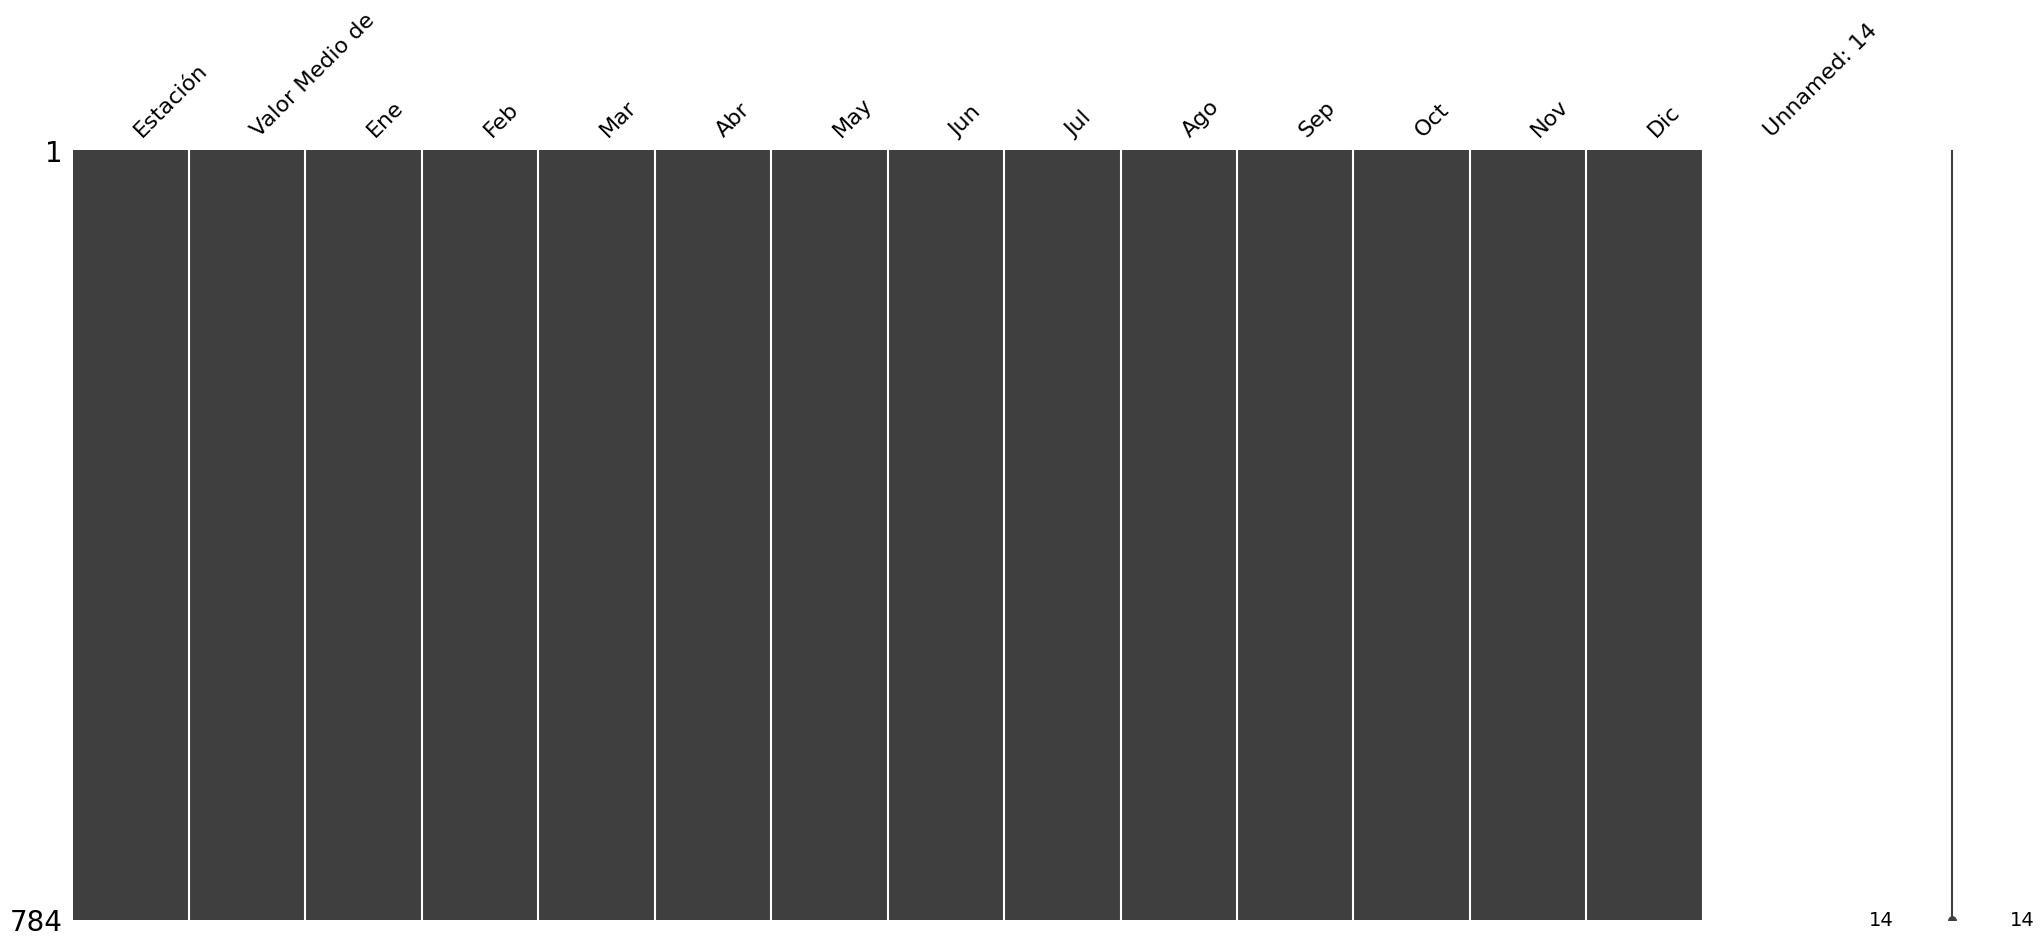

In [22]:
print('Visualizando los valores nulos')
msno.matrix(df_30_raw);

In [23]:
print("Estaciones únicas:")
print(df_30_raw['Estación'].nunique())

Estaciones únicas:
98


A partir de la inspección inicial del dataset `df_30_raw`, se observa lo siguiente:

- El dataset contiene estadísticas mensuales históricas normalizadas para múltiples estaciones meteorológicas, con datos promedio del período 1991–2020.
- Cada estación aparece repetida en filas distintas según la variable climática (temperatura, humedad, viento, etc.).
- Las variables están descritas en la columna `Valor Medio de`, y los valores correspondientes aparecen distribuidos en columnas mensuales: `Ene`, `Feb`, ..., `Dic`.
- Hay una columna adicional sin nombre útil (`Unnamed: 14`), que será descartada más adelante.
- Las estaciones están identificadas por nombre, pero no se incluye información geográfica adicional (provincia, latitud, etc.).
- Algunas filas incluyen variables agregadas como "Nubosidad total" o "Velocidad del Viento", y puede haber diferencias en la cantidad de años considerados para ciertas variables (por ejemplo, viento: 2011–2020).
- **Si bien a primera vista no se detectan valores faltantes (`NaN`) al ejecutar `isnull().sum()`, al observar los datos crudos y la matriz de datos faltantes se detecta que existen celdas con el texto `'S/D'` (Sin Dato), lo cual implica que estos valores están presentes pero no como `NaN`. Esto será tratado en la etapa de limpieza.**

Esta exploración inicial permite tener una idea general de la estructura y contenido del dataset antes de aplicar transformaciones para su análisis.



## 2.2 Aplicación de técnicas de visualización

Se aplican herramientas gráficas como histogramas, boxplots, líneas de tiempo y otros para explorar el comportamiento de las variables principales y detectar patrones, estacionalidades o valores atípicos.

---

### Dataset: registro_temperatura365d_smn

In [24]:
df_ly = df_ly_raw.copy() # Copia del dataframe original

# Quitar filas que no tengan una fecha válida (por ejemplo, si tienen guiones)
df_ly = df_ly[df_ly['FECHA'].str.fullmatch(r"\d{8}")] # Filtrar fechas con formato de 8 dígitos (día-mes-año) 

df_ly['FECHA'] = pd.to_datetime(df_ly['FECHA'], format = '%d%m%Y') # Convertir a fecha con formato día-mes-año
df_ly['TMAX'] = pd.to_numeric(df_ly['TMAX'], errors='coerce') # Ignorar errores de conversión a numérico (por ejemplo, guiones)
df_ly['TMIN'] = pd.to_numeric(df_ly['TMIN'], errors='coerce') # Ignorar errores de conversión a numérico (por ejemplo, guiones)
df_ly['NOMBRE'] = df_ly['NOMBRE'].astype('category') # Convertir a categoría

In [26]:
### Exportación para leer en otra Notebook

# Detectar columnas categóricas
categorical_cols = [col for col, dtype in df_ly.dtypes.items() if str(dtype) == 'category']

# Guardar los tipos como strings
dtypes_str = {col: str(dtype) for col, dtype in df_ly.dtypes.items()}

# Guardar todo en un solo JSON
info = {
    "dtypes": dtypes_str,
    "categoricals": categorical_cols
}

with open("Datos/df_ly_dtypes.json", "w") as f:
    json.dump(info, f)

# exportar CSV
df_ly.to_csv('Datos/df_ly.csv', index=False)


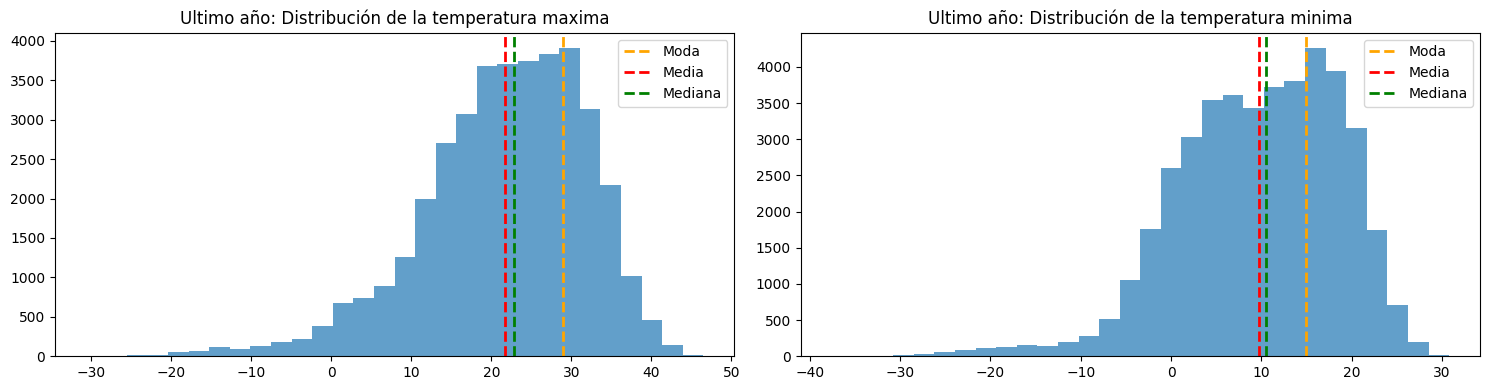

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Función para graficar
def plot_distribution(ax, data, title):
    ax.hist(data, bins=30, alpha=0.7) # dibujar histograma
    ax.axvline(data.mode()[0], color='orange', linestyle='dashed', linewidth=2, label='Moda') # dibujar la moda
    ax.axvline(data.mean(), color='red', linestyle='dashed', linewidth=2, label='Media') # dibujar la media
    ax.axvline(data.median(), color='green', linestyle='dashed', linewidth=2, label='Mediana') # dibujar la mediana
    ax.set_title(title)
    ax.legend()

plot_distribution(axes[0], df_ly['TMAX'], 'Ultimo año: Distribución de la temperatura maxima')
plot_distribution(axes[1], df_ly['TMIN'], 'Ultimo año: Distribución de la temperatura minima')

plt.tight_layout()
plt.show()

Se observan las distribuciones de temperaturas máximas y mínimas durante el último año. Las líneas verticales indican la moda (naranja), media (roja) y mediana (verde), lo que permite detectar asimetrías y valores típicos. La distribución es esperablemente amplia, dada la diversidad climática del país.

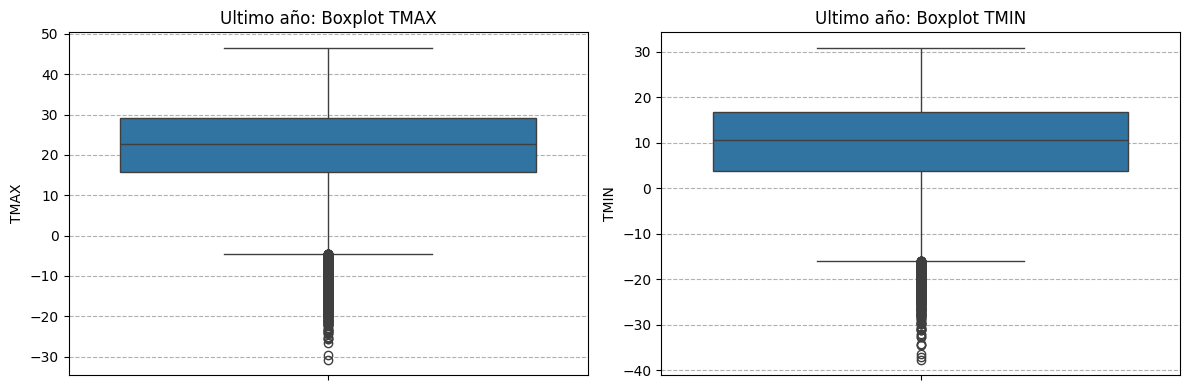

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

# ejemplo:
sns.boxplot(data=df_ly, y='TMAX', ax=ax[0])
sns.boxplot(data=df_ly, y='TMIN', ax=ax[1])

ax[0].grid(axis='y', ls='--')
ax[1].grid(axis='y', ls='--')
ax[0].set_title('Ultimo año: Boxplot TMAX')
ax[1].set_title('Ultimo año: Boxplot TMIN')

plt.tight_layout()
plt.show()

Los boxplots muestran la dispersión y los outliers en las temperaturas extremas. La presencia de valores atípicos es esperable debido a la inclusión de estaciones ubicadas en zonas con climas extremos (como la Base Marambio en la Antártida). No se eliminarán ya que representan fenómenos reales.

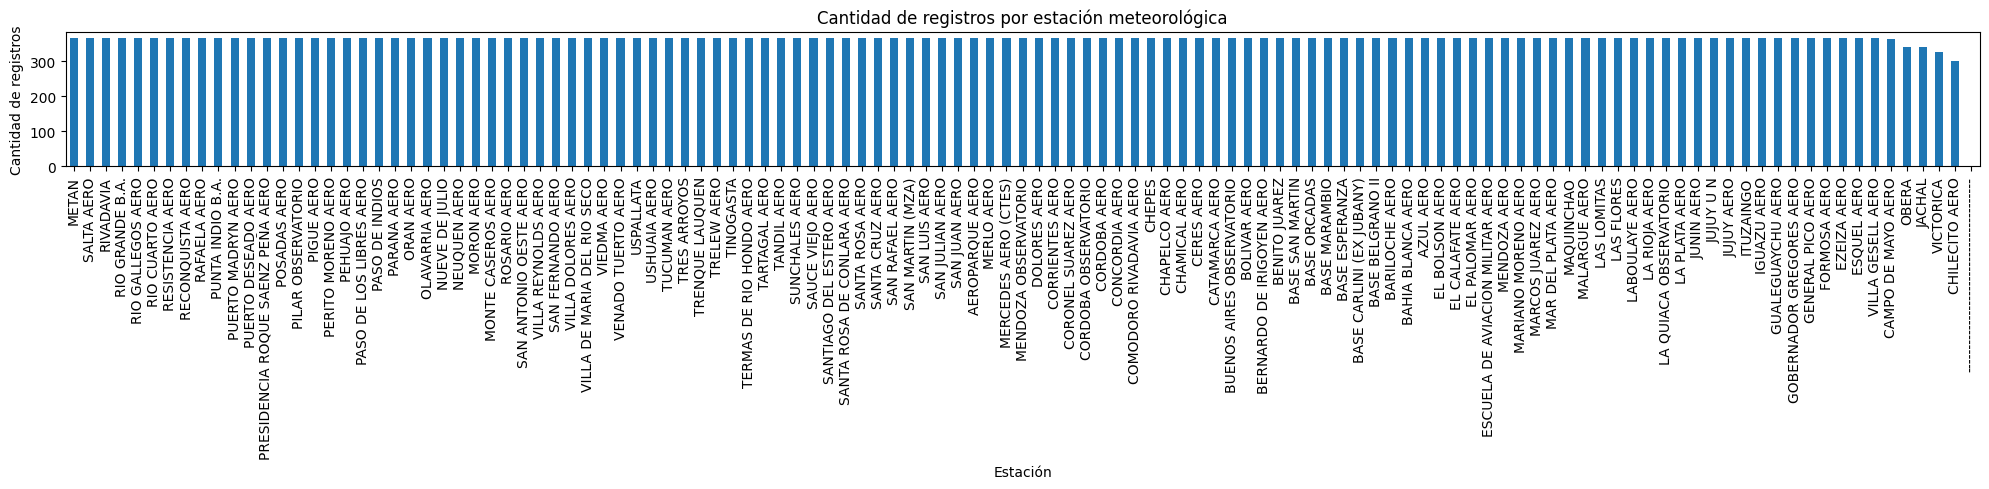

In [17]:
conteo = df_ly_raw['NOMBRE'].value_counts()

plt.figure(figsize=(20,5))
conteo.plot(kind='bar')
plt.title('Cantidad de registros por estación meteorológica')
plt.xlabel('Estación')
plt.ylabel('Cantidad de registros')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Aquí se muestra cuántos registros tiene cada estación meteorológica en el dataset. Algunas estaciones tienen menos de 365 registros, indicando posibles faltantes de datos o cortes en la recolección.

C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\3668180416.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incompletas = df_ly.groupby('NOMBRE').size()


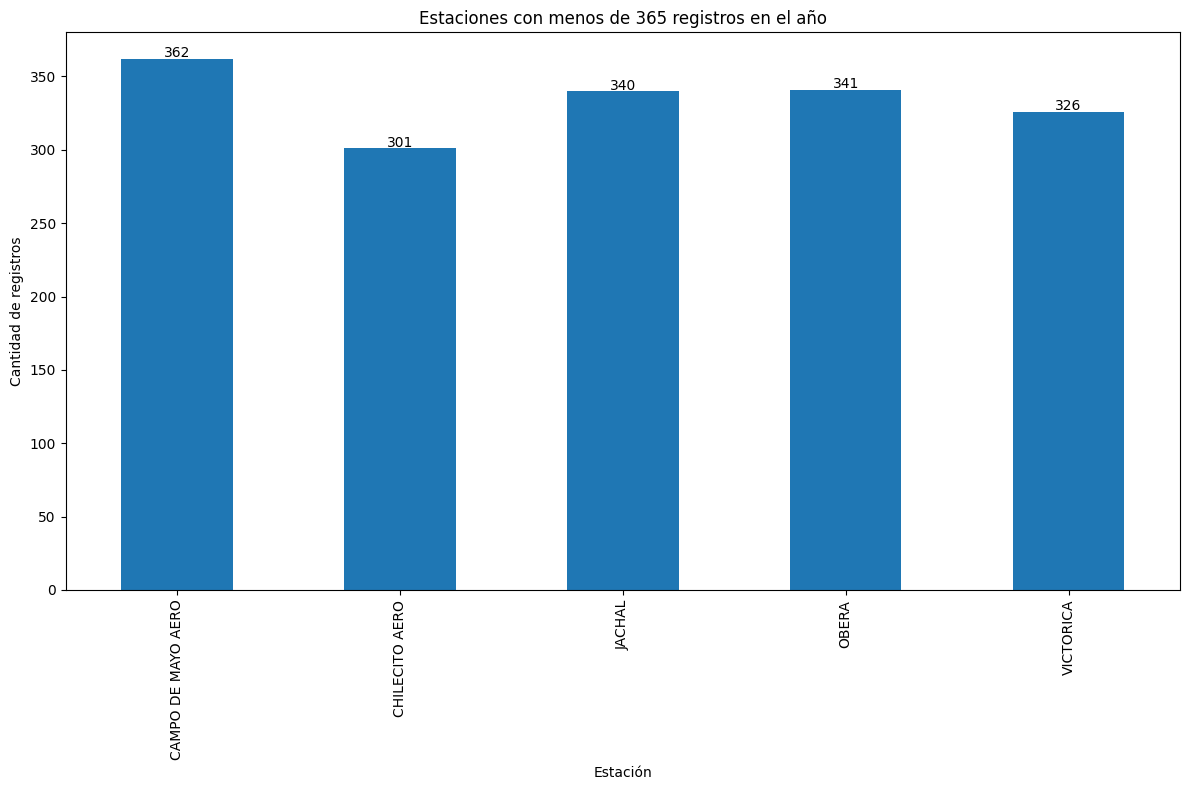

In [18]:
incompletas = df_ly.groupby('NOMBRE').size()
incompletas = incompletas[incompletas < 365]

plt.figure(figsize=(12,8))
ax = incompletas.plot(kind='bar')
plt.title('Estaciones con menos de 365 registros en el año')
plt.xlabel('Estación')
plt.ylabel('Cantidad de registros')
plt.xticks(rotation=90)

# Agregar valor encima de cada barra
for i, valor in enumerate(incompletas):
    plt.text(x=i, y=valor + 1, s=str(valor), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


Este gráfico enfoca exclusivamente en las estaciones que tienen datos incompletos (menos de 365 días registrados). Las barras más bajas indican estaciones con mayor cantidad de días faltantes. Esto permite detectar posibles problemas de cobertura o interrupciones en la recolección de datos.

### Dataset: Estadísticas normales Datos abiertos 1991-2020

In [19]:
# Copia y limpieza mínima
df_30 = df_30_raw.copy()
df_30 = df_30.drop(columns=["Unnamed: 14"], errors="ignore")

# Transformar a formato largo
df_30 = df_30.melt(
    id_vars=['Estación', 'Valor Medio de'],
    var_name='Mes',
    value_name='Valor'
)

# Convertir tipos
df_30['Estación'] = df_30['Estación'].astype('category')
df_30['Valor Medio de'] = df_30['Valor Medio de'].astype('category')
df_30['Valor'] = pd.to_numeric(df_30['Valor'], errors='coerce')

# Convertir Mes a categoría ordenada (enero a diciembre)
df_30['Mes'] = pd.Categorical(
    df_30['Mes'],
    categories=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'],
    ordered=True
)


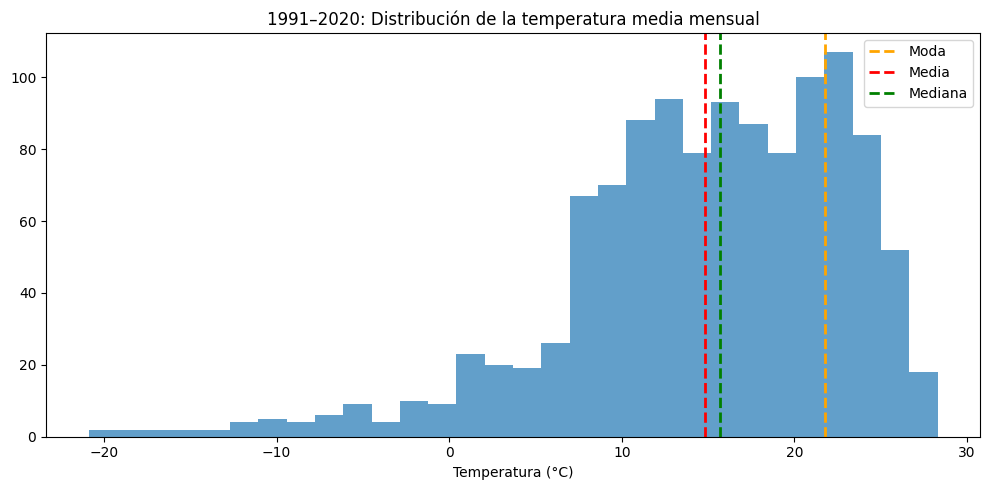

In [20]:
# Filtrar solo filas con temperatura media
df_temp_media = df_30[df_30['Valor Medio de'] == 'Temperatura (°C)'].copy()

# Crear figura y eje
fig, ax = plt.subplots(figsize=(10, 5))

# Dibujar histograma
ax.hist(df_temp_media['Valor'].dropna(), bins=30, alpha=0.7)
ax.axvline(df_temp_media['Valor'].mode()[0], color='orange', linestyle='dashed', linewidth=2, label='Moda')
ax.axvline(df_temp_media['Valor'].mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
ax.axvline(df_temp_media['Valor'].median(), color='green', linestyle='dashed', linewidth=2, label='Mediana')

# Etiquetas y título
ax.set_title('1991–2020: Distribución de la temperatura media mensual')
ax.set_xlabel('Temperatura (°C)')
ax.legend()

plt.tight_layout()
plt.show()

Distribución de la temperatura media mensual (1991–2020)

En este gráfico se muestra la distribución de las temperaturas medias mensuales, calculadas a partir de los valores históricos del período 1991–2020 para todas las estaciones meteorológicas del país.

- La mayoría de los valores se concentran entre los **10 °C y 25 °C**, con una **moda** levemente por encima de los 20 °C.
- También se observan valores negativos, correspondientes a zonas frías como la Patagonia o regiones de altura.
- Las líneas punteadas indican:
  - **Moda** (naranja): el valor más frecuente.
  - **Media** (roja): promedio de todos los valores.
  - **Mediana** (verde): valor central.
- La distribución presenta una leve asimetría negativa (cola hacia la izquierda), indicando la presencia de registros fríos pero poco frecuentes.

Este análisis ofrece una primera mirada a los rangos térmicos más comunes en Argentina a lo largo de las estaciones del año.


In [21]:
# Calcular el promedio anual por estación y variable
df_anual = df_30.groupby(['Estación', 'Valor Medio de'], as_index=False)['Valor'].mean()

# Filtrar y renombrar variables clave
variables_interes = [
    'Temperatura (°C)',
    'Humedad relativa (%)',
    'Velocidad del Viento (km/h) (2011-2020)',
    'Precipitación (mm)'
]
nombre_vars = {
    'Temperatura (°C)': 'Temperatura media (°C)',
    'Humedad relativa (%)': 'Humedad relativa (%)',
    'Velocidad del Viento (km/h) (2011-2020)': 'Viento (km/h)',
    'Precipitación (mm)': 'Precipitación (mm)'
}
df_anual = df_anual[df_anual['Valor Medio de'].isin(variables_interes)].copy()
df_anual['Variable'] = df_anual['Valor Medio de'].map(nombre_vars)


C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\3078973787.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_anual = df_30.groupby(['Estación', 'Valor Medio de'], as_index=False)['Valor'].mean()


Boxplots del promedio anual (1991–2020) por estación meteorológica

En los siguientes gráficos se representa la distribución del promedio anual para cada variable climática relevante, considerando los valores medios mensuales de todas las estaciones meteorológicas del país durante el período 1991–2020:

- **Temperatura media (°C):** muestra una dispersión relativamente baja, con la mayoría de las estaciones en el rango de 10 °C a 20 °C.
- **Humedad relativa (%):** se encuentra mayormente entre el 40 % y el 70 %, con algunas estaciones más secas o más húmedas.
- **Velocidad del viento (km/h):** los valores son en general bajos, y se mantiene una distribución algo más amplia, aunque moderada.
- **Precipitación (mm):** presenta una alta variabilidad, lo cual es esperable dada la diversidad climática del país, desde zonas áridas a tropicales.

Estos gráficos permiten identificar rápidamente la variabilidad entre estaciones y ayudan a contextualizar los patrones climáticos regionales de Argentina.


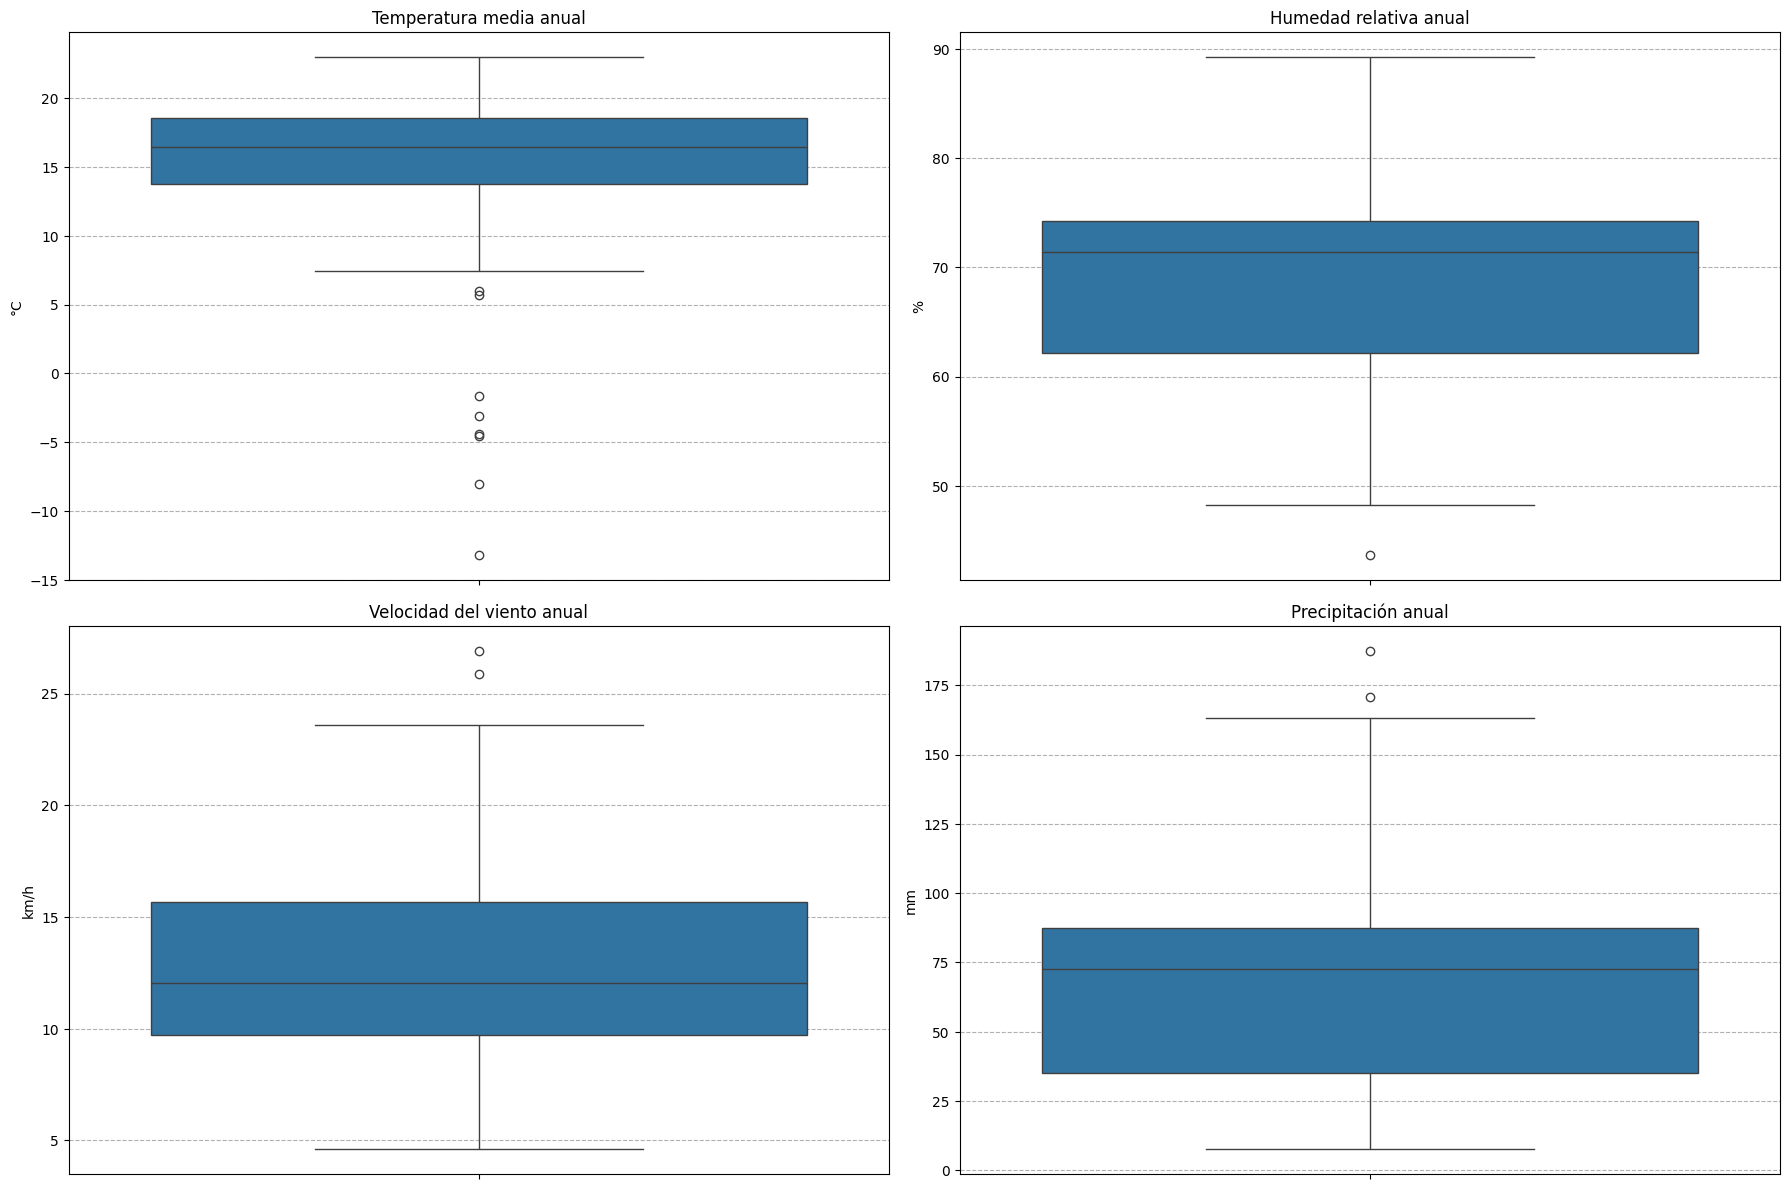

In [22]:
# Crear subplots para cada variable
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Variables y títulos
variables = [
    ('Temperatura media (°C)', 'Temperatura media anual'),
    ('Humedad relativa (%)', 'Humedad relativa anual'),
    ('Viento (km/h)', 'Velocidad del viento anual'),
    ('Precipitación (mm)', 'Precipitación anual')
]

# Dibujar los boxplots
for ax, (var, titulo) in zip(axes.flat, variables):
    datos = df_anual[df_anual['Variable'] == var]
    sns.boxplot(data=datos, y='Valor', ax=ax)
    ax.set_title(titulo)
    ax.grid(axis='y', linestyle='--')
    
axes[0,0].set_ylabel('°C')
axes[0,1].set_ylabel('%')
axes[1,0].set_ylabel('km/h')
axes[1,1].set_ylabel('mm')

plt.tight_layout()
plt.show()


Estaciones meteorológicas con datos faltantes

El siguiente gráfico muestra la cantidad total de valores faltantes (`NaN`) por estación meteorológica en el dataset histórico 1991–2020. 

Estos valores faltantes provienen originalmente de celdas marcadas como `'S/D'` (Sin Dato) en el archivo crudo, y fueron convertidos explícitamente a `NaN` durante la etapa de formateo.

- Algunas estaciones presentan registros faltantes en múltiples meses y variables, lo que puede afectar los análisis posteriores.
- Este tipo de visualización permite identificar si los faltantes están concentrados en ciertas estaciones (por ejemplo, remotas o con bajo mantenimiento).
- No se ha realizado todavía ningún proceso de imputación o eliminación sobre estos datos, pero estas estaciones podrían ser tratadas de forma diferencial más adelante.

Este análisis exploratorio es clave para anticipar decisiones de limpieza y modelado.


C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\1909623450.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  faltantes_por_estacion = df_30[df_30['Valor'].isna()].groupby('Estación').size().sort_values(ascending=False)


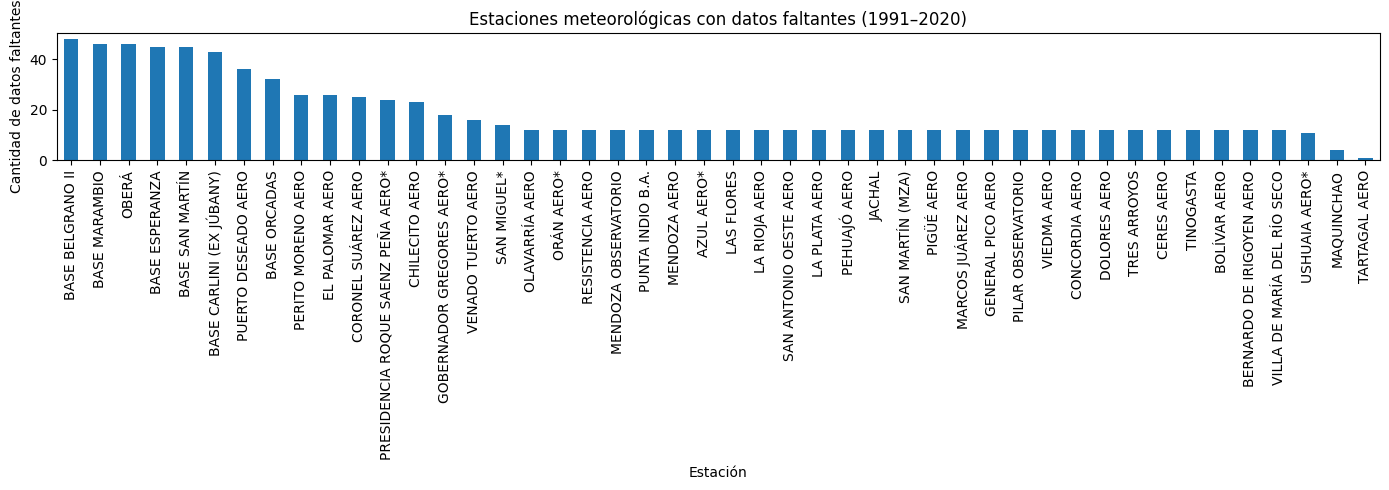

In [23]:
faltantes_por_estacion = df_30[df_30['Valor'].isna()].groupby('Estación').size().sort_values(ascending=False)
faltantes_por_estacion = faltantes_por_estacion[faltantes_por_estacion > 0]

plt.figure(figsize=(14, 5))
faltantes_por_estacion.plot(kind='bar')
plt.ylabel('Cantidad de datos faltantes')
plt.title('Estaciones meteorológicas con datos faltantes (1991–2020)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


---

En esta sección se procesó el dataset histórico del período 1991–2020 (`df_30`), transformándolo al formato largo para facilitar su análisis. Se aplicaron conversiones de tipo, se identificaron datos faltantes y se realizaron múltiples visualizaciones exploratorias:

- Se creó un histograma de temperaturas medias mensuales para observar la distribución general de los valores en todo el país.
- Se construyeron boxplots mensuales por variable climática (temperatura, humedad, viento y precipitación), permitiendo observar estacionalidades y rangos típicos.
- Se analizaron los promedios anuales por estación meteorológica, y se representaron mediante boxplots separados para cada variable.
- Finalmente, se identificaron y graficaron las estaciones con datos faltantes, anticipando la necesidad de tratamientos diferenciales o imputaciones en etapas posteriores.

Esta exploración permite comprender tanto la estructura como el comportamiento general del clima en Argentina durante el período analizado, y prepara el terreno para etapas de limpieza, enriquecimiento y comparación con el último año.


## 2.3 Limpieza del dataset

Aquí se aplican técnicas para tratar valores nulos, inconsistencias, tipos incorrectos o datos duplicados. Se definen reglas de limpieza y se transforman columnas para facilitar el análisis posterior.

---

### Dataset: registro_temperatura365d_smn

En esta etapa se completan las tareas de limpieza del dataset `df_ly`, que fue creado previamente como copia del original (`df_ly_raw`).

- Se eliminaron filas con fechas inválidas, conservando únicamente aquellas con formato numérico de 8 dígitos (DDMMAAAA).
- Se convirtieron las columnas `TMAX` y `TMIN` a tipo numérico, generando valores `NaN` en aquellas celdas que contenían guiones u otros valores no interpretables como números.
- La columna `FECHA` se transformó a tipo `datetime` para facilitar operaciones temporales.
- Se detectaron valores faltantes (`NaN`) en las columnas de temperatura. Se considera que estos valores son del tipo **MAR (Missing At Random)**, ya que suelen depender de la estación meteorológica y no del valor ausente en sí.

Tratamiento de datos faltantes

Como estrategia de imputación, se propone rellenar los valores faltantes con la **temperatura promedio mensual de la misma estación**, ya que esto respeta la variabilidad estacional y regional de los datos.

La limpieza realizada garantiza que los datos estén en formato coherente y listos para la transformación y extracción de nuevas variables.


C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\2911852236.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ly[col] = df_ly.groupby(['NOMBRE', 'MES'])[col].transform(lambda x: x.fillna(x.mean()))
C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\2911852236.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ly[col] = df_ly.groupby('NOMBRE')[col].transform(lambda x: x.fillna(x.mean()))


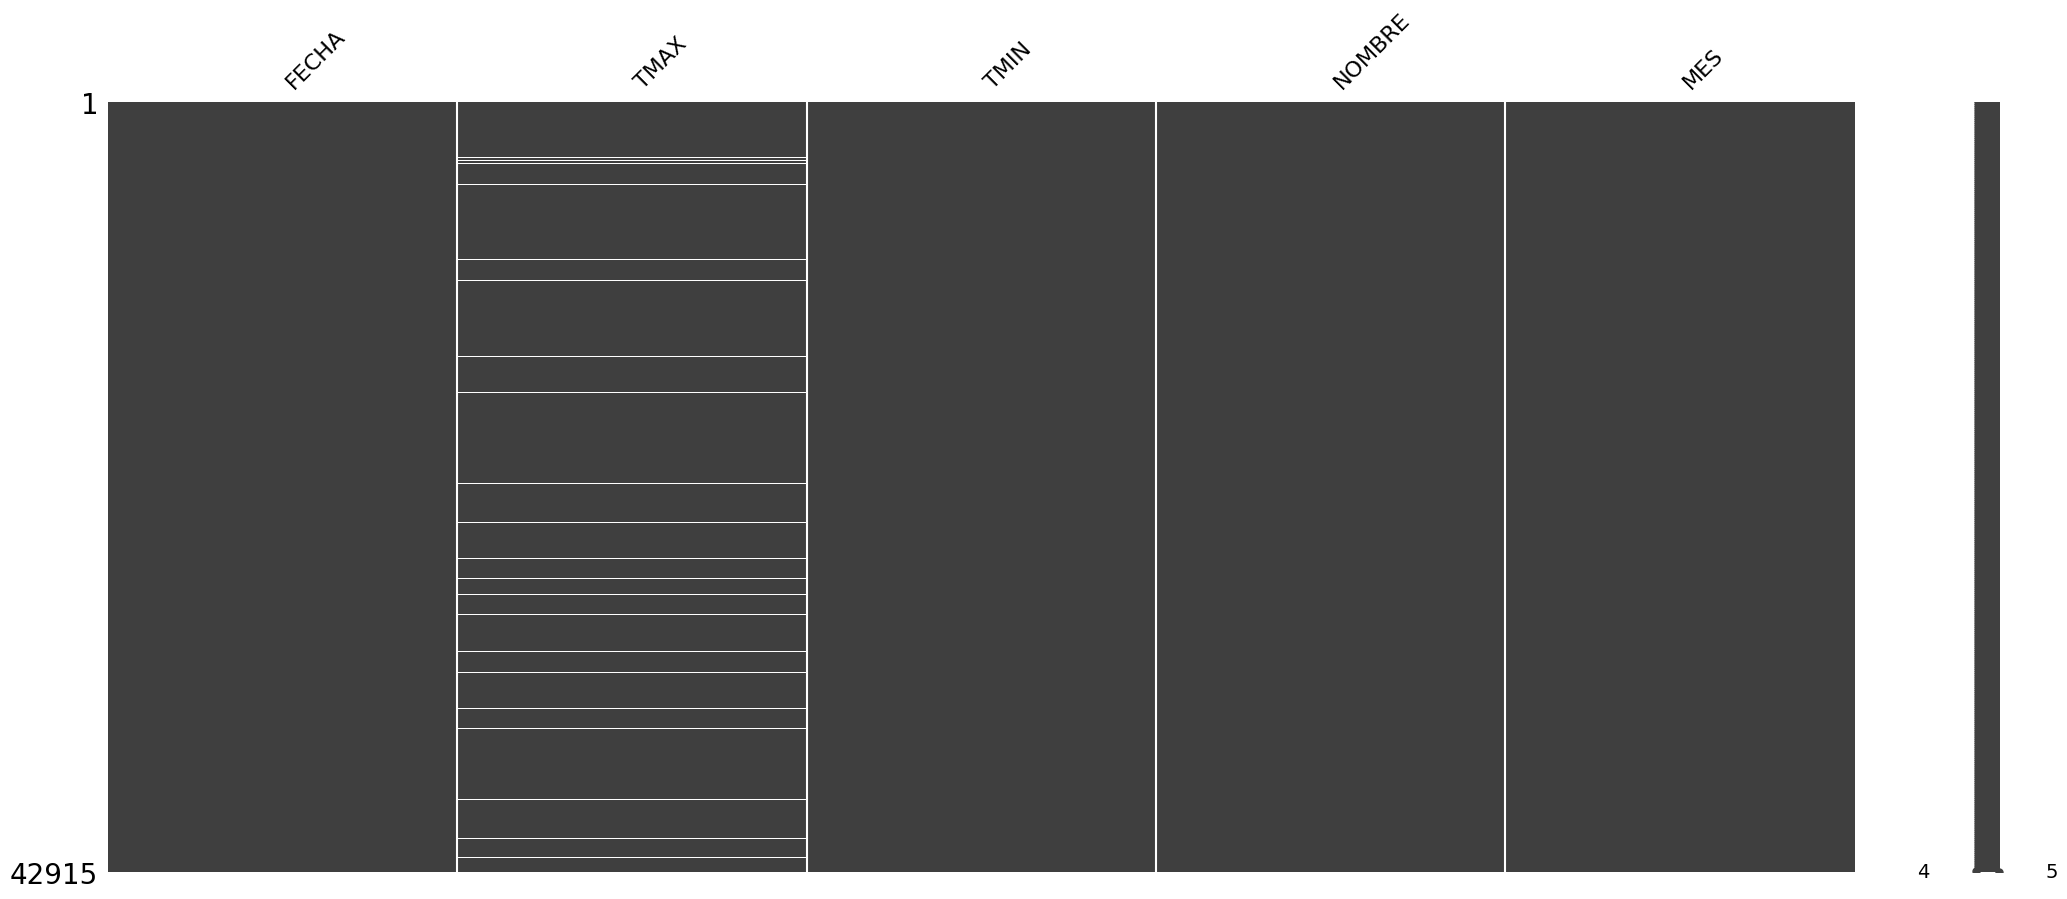

In [24]:
# Agregar columna auxiliar del mes
df_ly['MES'] = df_ly['FECHA'].dt.month

# Imputación en dos pasos: mensual por estación → anual por estación
for col in ['TMAX', 'TMIN']:
    # Paso 1: promedio mensual por estación
    df_ly[col] = df_ly.groupby(['NOMBRE', 'MES'])[col].transform(lambda x: x.fillna(x.mean()))
    # paso filtrar knn
    # Paso 2: si aún quedan NaNs, usar promedio anual por estación
    df_ly[col] = df_ly.groupby('NOMBRE')[col].transform(lambda x: x.fillna(x.mean()))


msno.matrix(df_ly);

#### Clasificación del tipo de faltante en TMAX

Inicialmente, se clasificaron como MNAR las observaciones de `TMAX` faltantes en las estaciones "CHAMICAL AERO", "ESCUELA DE AVIACION MILITAR AERO" y "RIO CUARTO AERO", ya que todas las observaciones de esa variable estaban ausentes en dichas estaciones.

Sin embargo, al observar que las temperaturas mínimas (`TMIN`) estaban registradas y que la estación, mes y región eran conocidos, se reconsideró el tipo de faltante. Se concluyó que `TMAX` podría imputarse utilizando `TMIN` y la **amplitud térmica promedio** por región y mes, por lo tanto, este faltante se ajusta a la categoría **MAR** (Missing At Random).

#### Imputación por amplitud térmica regional

Se calculó la amplitud térmica media (`TMAX - TMIN`) para cada combinación de región y mes, y luego se imputó `TMAX` como:

TMAX ≈ TMIN + amplitud_media(REGION, MES)

In [25]:
# Cargar diccionario de regiones actualizado
region_map = pd.read_csv("estaciones_con_regiones.csv")

# Crear la columna REGION (necesaria para imputación por amplitud térmica)
region_dict = dict(zip(region_map["NOMBRE"], region_map["REGION"]))
df_ly["REGION"] = df_ly["NOMBRE"].map(region_dict)

# Calcular amplitud térmica promedio por región y mes
df_ly["AMP_TERM"] = df_ly["TMAX"] - df_ly["TMIN"]
amplitud_region_mes = df_ly.groupby(["REGION", "MES"])["AMP_TERM"].mean()

# Imputar TMAX faltantes usando TMIN + amplitud térmica promedio regional mensual
def imputar_tmax_por_amplitud(row):
    if pd.isna(row["TMAX"]) and pd.notna(row["TMIN"]):
        try:
            return row["TMIN"] + amplitud_region_mes.loc[(row["REGION"], row["MES"])]
        except KeyError:
            return row["TMAX"]
    return row["TMAX"]

df_ly["TMAX"] = df_ly.apply(imputar_tmax_por_amplitud, axis=1)

# Eliminar columna auxiliar usada en la imputación
df_ly.drop(columns=["AMP_TERM"], inplace=True)



Esta estrategia aprovecha patrones climáticos regionales estables y permite reconstruir los datos sin eliminar estaciones.

La columna `AMP_TERM` fue utilizada exclusivamente como variable auxiliar para imputar valores faltantes en `TMAX` a partir de `TMIN` y la amplitud térmica promedio regional y mensual. Como no será utilizada en los análisis posteriores y presenta una proporción de valores faltantes, se decidió eliminarla del dataset final.


In [26]:
print('Cantidad de valores nulos por columna')
df_ly.isnull().sum()

Cantidad de valores nulos por columna


FECHA     0
TMAX      0
TMIN      0
NOMBRE    0
MES       0
REGION    0
dtype: int64

In [27]:
# # Ver qué combinaciones de NOMBRE y MES tienen todas las TMAX en NaN
# faltantes_graves = df_ly.groupby(['NOMBRE', 'MES'])['TMAX'].apply(lambda x: x.isna().all())
# faltantes_graves = faltantes_graves.fillna(False)  # ← esto evita el error
# faltantes_graves[faltantes_graves].index.tolist()

In [28]:
# estaciones_sin_tmax = df_ly.groupby('NOMBRE')['TMAX'].apply(lambda x: x.isna().all())
# estaciones_sin_tmax[estaciones_sin_tmax].index.tolist()


Al analizar los valores faltantes de la variable `TMAX`, se detectó que los más de 1000 valores ausentes se concentran exclusivamente en tres estaciones meteorológicas:

- CHAMICAL AERO  
- ESCUELA DE AVIACION MILITAR AERO  
- RIO CUARTO AERO

Esto indica que los faltantes no se distribuyen aleatoriamente, ni responden a condiciones estacionales, sino que afectan de forma sistemática a ciertos puntos de medición. En este contexto, se clasifican como **faltantes del tipo MNAR (Missing Not At Random)**, ya que su aparición depende de la estación y no del valor ausente.

Dado que estas estaciones no cuentan con información suficiente para una imputación fiable, se optará por excluirlas del análisis posterior para evitar sesgos artificiales en los resultados.


In [29]:
# # Estaciones con todos los TMAX ausentes
# estaciones_excluir = ['CHAMICAL AERO', 'ESCUELA DE AVIACION MILITAR AERO', 'RIO CUARTO AERO']
# df_ly = df_ly[~df_ly['NOMBRE'].isin(estaciones_excluir)]

# msno.matrix(df_ly);

### Dataset: Estadísticas normales Datos abiertos 1991-2020

En esta sección se abordan las tareas necesarias para dejar el dataset histórico (`df_30`) en condiciones óptimas para su análisis comparativo y cruzado con otros conjuntos de datos.

Cabe destacar que parte de la limpieza ya fue realizada durante la etapa de transformación en la sección anterior:

- El dataset fue convertido al formato largo, facilitando su exploración por mes, estación y variable.
- Se eliminaron columnas vacías (`Unnamed: 14`) y se homogeneizaron los tipos de datos.
- Los valores marcados como `'S/D'` (Sin Dato) en el archivo crudo fueron convertidos explícitamente a `NaN`, lo que permitió identificar correctamente los datos faltantes.

A continuación, se analizará la distribución de valores nulos por variable y por mes, con el objetivo de decidir posibles estrategias de imputación o eliminación.

---

Análisis de valores faltantes por variable y por mes

En lugar de utilizar una matriz de calor tradicional para visualizar los valores faltantes (típica en datasets en formato ancho), se optó por una representación alternativa más adecuada al formato largo de este dataset.

El gráfico de la izquierda muestra cuántos valores faltantes (`NaN`) hay por cada **variable climática**. El de la derecha, por su parte, presenta la distribución de faltantes a lo largo de los **meses del año**.

Este análisis permite reflexionar sobre la naturaleza de los datos faltantes:

- Algunas variables como el viento o la nubosidad suelen tener más registros faltantes, probablemente por limitaciones en la disponibilidad histórica o cambios de instrumentos.
- En los meses de invierno o verano pueden concentrarse más faltantes en ciertas estaciones, lo cual podría relacionarse con condiciones operativas adversas.
- Si los faltantes están distribuidos de manera sistemática, podría tratarse de un patrón **MAR** (faltantes al azar condicionales). Si además dependen de la variable misma (por ejemplo, solo falta nubosidad en lugares muy secos), podrían ser incluso **MNAR** (faltantes no al azar).

Este diagnóstico orientará las decisiones sobre imputación, descarte o modelado específico de valores ausentes.


C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\326441714.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  faltantes_por_variable = df_30[df_30['Valor'].isna()].groupby('Valor Medio de').size().sort_values(ascending=False)
C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\326441714.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  faltantes_por_mes = df_30[df_30['Valor'].isna()].groupby('Mes').size().reindex(df_30['Mes'].cat.categories)


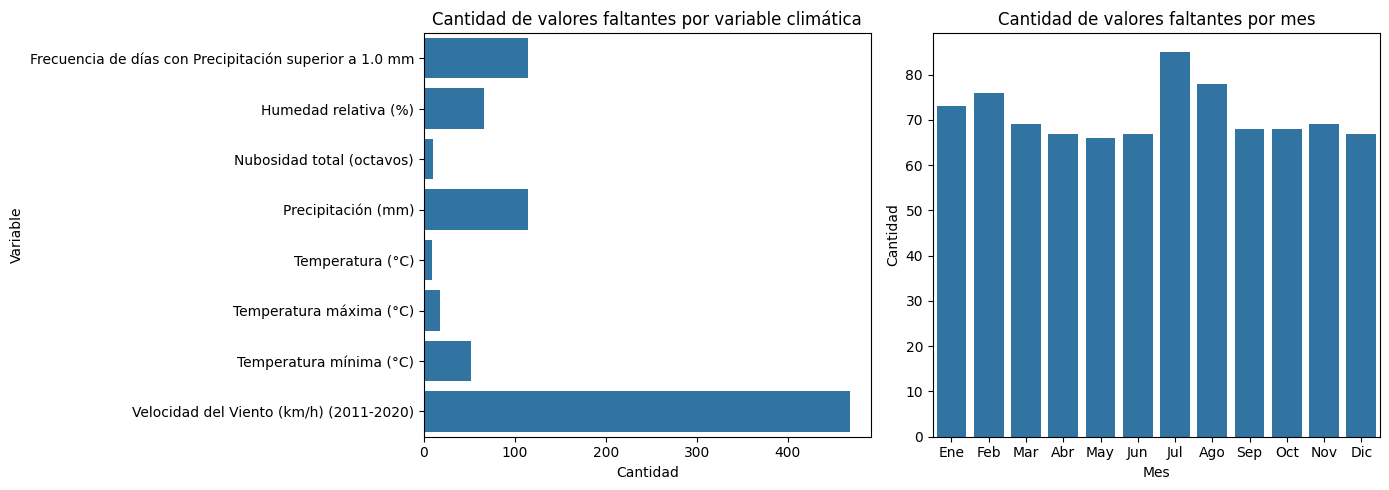

In [30]:
# Contar valores faltantes por variable climática
faltantes_por_variable = df_30[df_30['Valor'].isna()].groupby('Valor Medio de').size().sort_values(ascending=False)

# Contar valores faltantes por mes
faltantes_por_mes = df_30[df_30['Valor'].isna()].groupby('Mes').size().reindex(df_30['Mes'].cat.categories)

# Crear gráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico por variable
sns.barplot(x=faltantes_por_variable.values, y=faltantes_por_variable.index, ax=axes[0])
axes[0].set_title('Cantidad de valores faltantes por variable climática')
axes[0].set_xlabel('Cantidad')
axes[0].set_ylabel('Variable')

# Gráfico por mes
sns.barplot(x=faltantes_por_mes.index, y=faltantes_por_mes.values, ax=axes[1])
axes[1].set_title('Cantidad de valores faltantes por mes')
axes[1].set_xlabel('Mes')
axes[1].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()


<u>Tratamiento de valores faltantes (MAR)</u>

A partir del análisis anterior, se concluye que la mayoría de los valores faltantes en el dataset histórico pueden clasificarse como **MAR** (faltantes al azar condicionales). Esto significa que su ausencia está relacionada con variables observables como:

- El tipo de variable climática (por ejemplo, viento o nubosidad tienen más faltantes).
- La estación meteorológica (algunas tienen sensores incompletos o se incorporaron más tarde).
- El mes del año (puede haber menos registros en invierno por limitaciones operativas).

Dado que los valores faltantes MAR pueden estimarse razonablemente a partir de otras variables observadas, se considera apropiado aplicar **técnicas de imputación** para su tratamiento.
> ⚠️ Nota: Si una estación **nunca reportó datos** para una variable en todo el período, es probable que se trate de un caso **MNAR**, y en ese caso no se recomienda imputar sino tratarlo como un dato estructuralmente ausente.

En la siguiente etapa se aplicará una imputación controlada, priorizando el uso de promedios agrupados para mantener la coherencia interna del dataset.


## 2.4 Transformación de variables y selección de features

Se transforman variables según sea necesario (por ejemplo, crear una temperatura media entre TMAX y TMIN, extraer mes o estación del año desde la fecha, etc.). También se seleccionan las variables más relevantes para el análisis.

---

### Dataset: registro_temperatura365d_smn

> ⚠️ **Nota aclaratoria:**
> 
> La variable `REGION`, aunque conceptualmente forma parte de esta sección dedicada a la creación de nuevas variables, fue incorporada previamente en la sección 2.3. Esto se debió a que su existencia era necesaria para realizar una imputación fundamentada de valores faltantes en la variable `TMAX`.
> 
> En particular, se utilizó `REGION` junto con `MES` y `TMIN` para estimar `TMAX` en ciertas estaciones con faltantes totales, utilizando la amplitud térmica promedio regional. Por este motivo, se adelantó su creación en el flujo del trabajo, aunque se discute aquí como transformación relevante.


En esta sección se crean nuevas variables derivadas del dataset original con el objetivo de facilitar el análisis y la construcción de posibles modelos. Estas transformaciones permiten simplificar el comportamiento de ciertas variables, capturar tendencias temporales y reducir la complejidad del dataset sin perder información relevante.


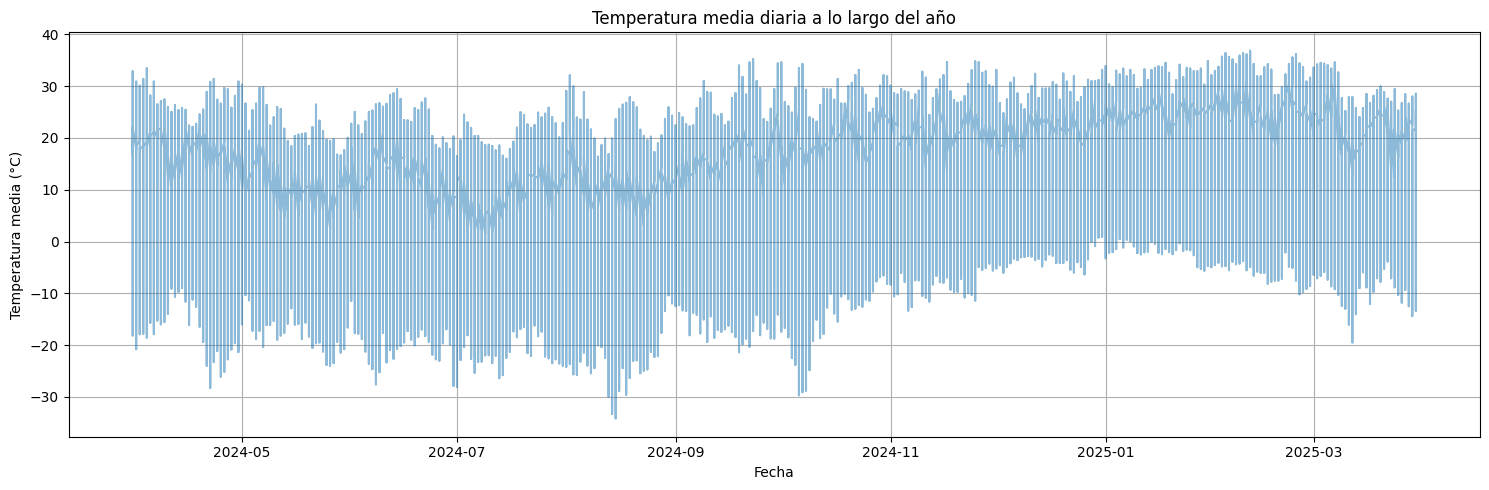

In [31]:
df_ly['TEMP_MEDIA'] = (df_ly['TMAX'] + df_ly['TMIN']) / 2

plt.figure(figsize=(15,5))
plt.plot(df_ly['FECHA'], df_ly['TEMP_MEDIA'], alpha=0.5)
plt.title('Temperatura media diaria a lo largo del año')
plt.xlabel('Fecha')
plt.ylabel('Temperatura media (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

Este gráfico permite observar la evolución de la temperatura media diaria a lo largo del año. Se visualiza una estacionalidad clara con máximos en verano y mínimos en invierno, como es característico en el hemisferio sur.

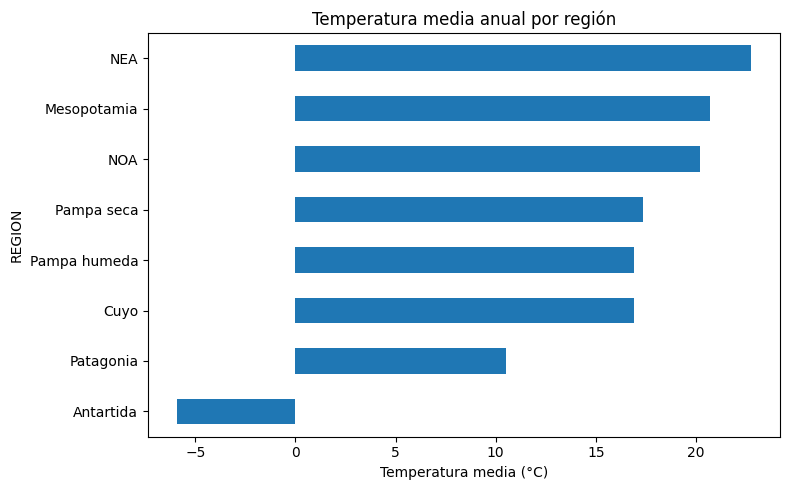

In [32]:
# Agrupar por región y calcular media
media_por_region = df_ly.groupby('REGION')['TEMP_MEDIA'].mean().sort_values()

# Gráfico de barras horizontales
media_por_region.plot(kind='barh', figsize=(8, 5), title='Temperatura media anual por región')
plt.xlabel('Temperatura media (°C)')
plt.tight_layout()
plt.show()


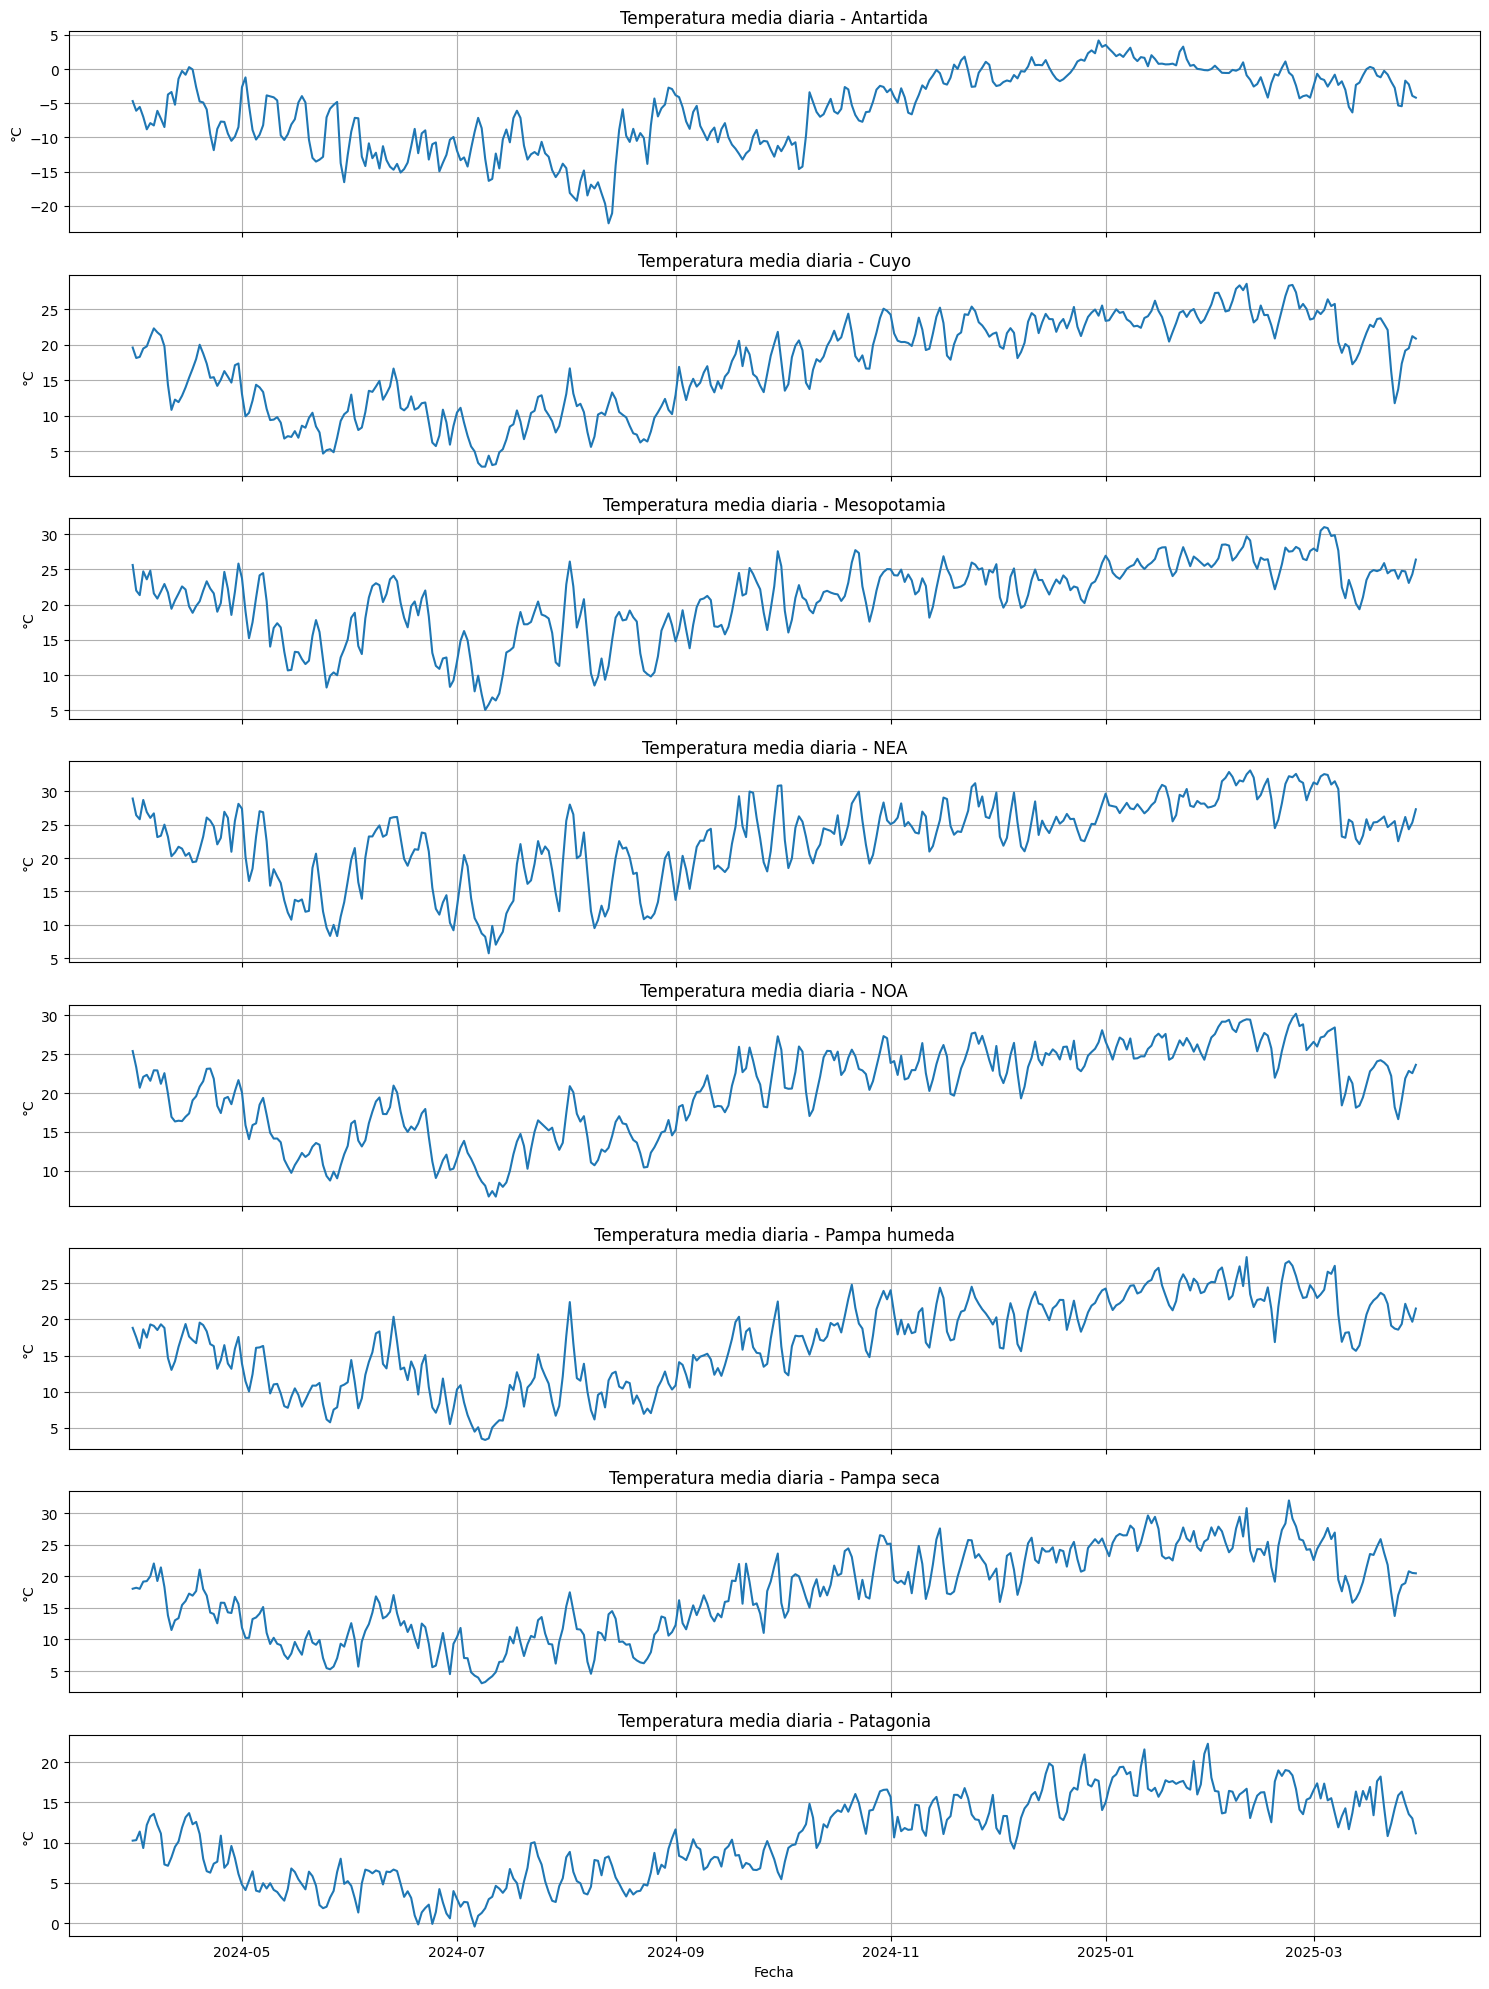

In [33]:
# Ordenamos por fecha por seguridad
df_ly = df_ly.sort_values('FECHA')

# Agrupamos por región
regiones = df_ly['REGION'].dropna().unique()
n = len(regiones)

# Creamos los subplots
fig, axes = plt.subplots(n, 1, figsize=(15, 2.5 * n), sharex=True)

for i, region in enumerate(sorted(regiones)):
    ax = axes[i]
    subset = df_ly[df_ly['REGION'] == region]
    media_diaria = subset.groupby('FECHA')['TEMP_MEDIA'].mean()
    ax.plot(media_diaria.index, media_diaria.values, label=region)
    ax.set_title(f"Temperatura media diaria - {region}")
    ax.set_ylabel("°C")
    ax.grid(True)

axes[-1].set_xlabel("Fecha")
plt.tight_layout()
plt.show()


Se calcula la temperatura media anual para cada región geográfica. Esto permite observar la variabilidad térmica en el país y detectar regiones con climas más extremos o templados.

La región más cálida del último año fue el noreste argentino y la más fría fue antartida, lo cual concuerda con las características climáticas esperadas.

C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\3610457072.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='REGION', y='TEMP_MEDIA', data=df_ly, palette='Set2')


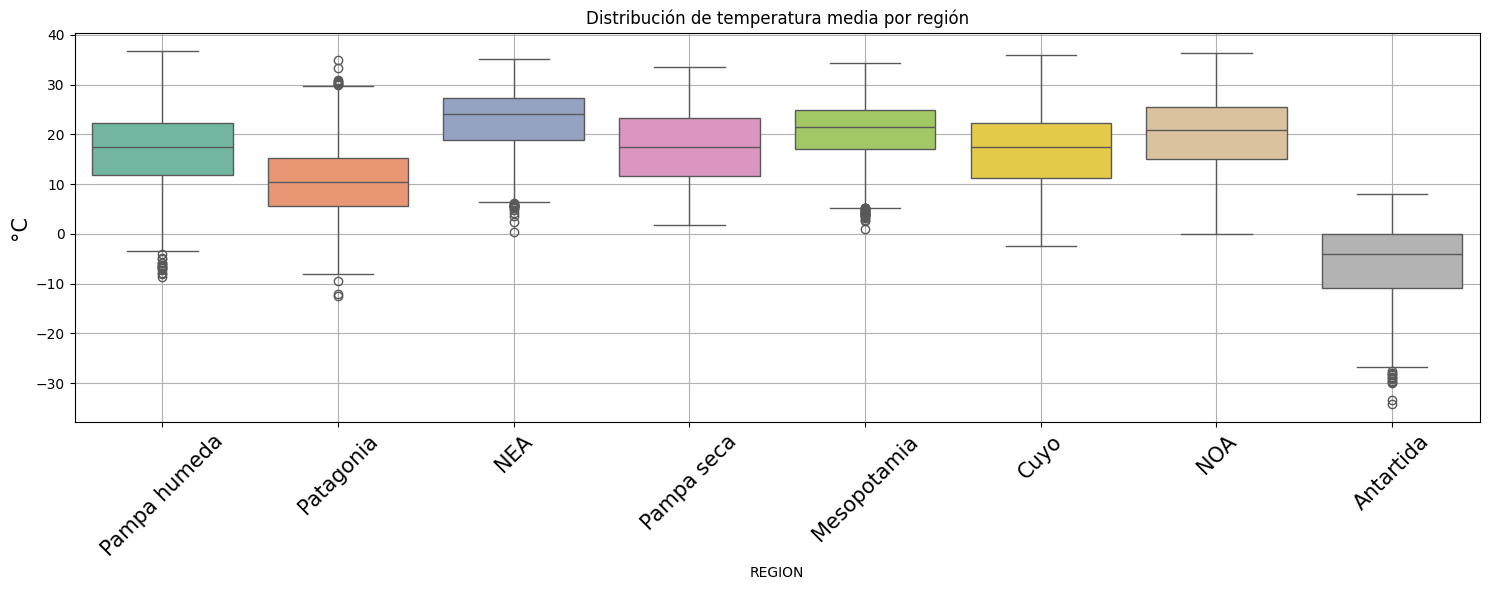

In [34]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='REGION', y='TEMP_MEDIA', data=df_ly, palette='Set2')
plt.title('Distribución de temperatura media por región')
plt.ylabel('°C', fontsize=15)
plt.xticks(rotation=45, fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()


Distribución de temperatura media por región

El boxplot permite observar la dispersión de las temperaturas medias registradas a lo largo del año para cada región. Se destacan:

- Las regiones **NEA** y **Mesopotamia**, con valores más altos y menor variabilidad.
- La **Antártida**, con temperaturas negativas y un rango más comprimido.
- **NOA** y **Cuyo** presentan una mayor amplitud térmica, lo cual refleja diferencias de altitud y continentalidad.
- Los outliers en algunas regiones corresponden a registros extremos propios de zonas particulares dentro de cada región.

Esta visualización es útil para detectar asimetrías, extremos térmicos y superposición de distribuciones.


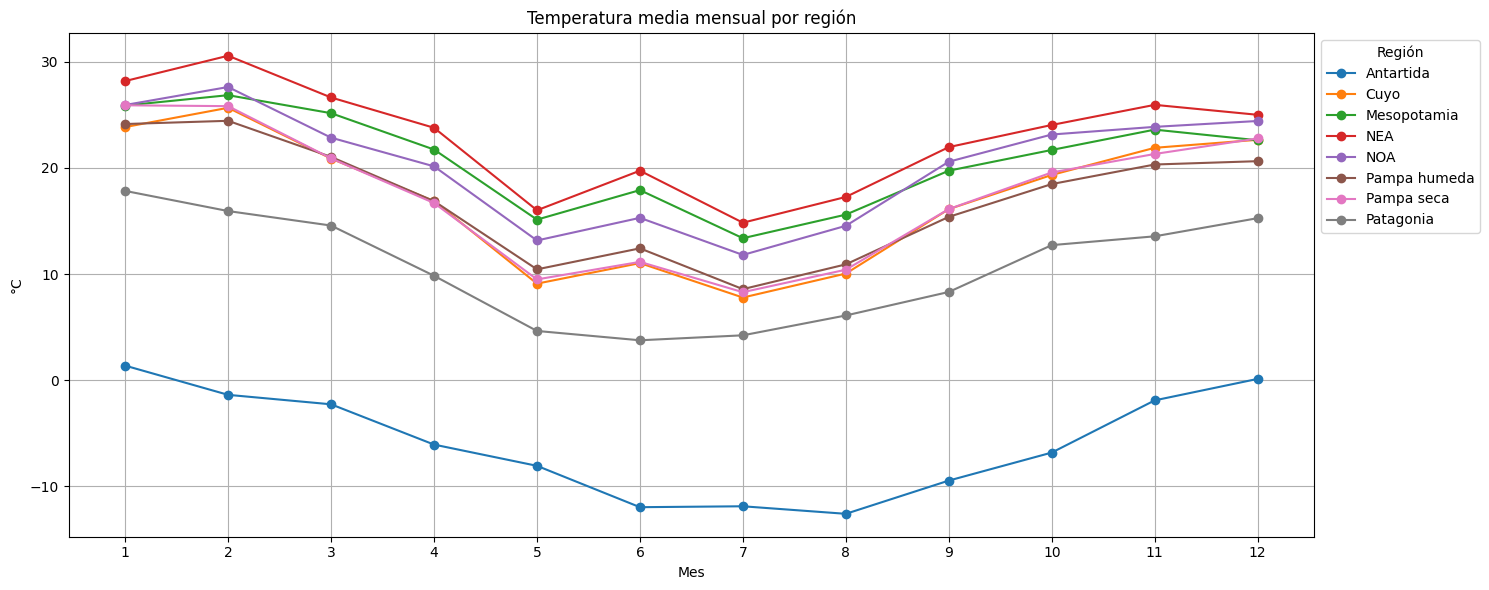

In [35]:
# Agrupar por mes y región
mensual = df_ly.groupby(['REGION', 'MES'])['TEMP_MEDIA'].mean().reset_index()

# Graficar
plt.figure(figsize=(15, 6))
for region in sorted(df_ly['REGION'].dropna().unique()):
    datos = mensual[mensual['REGION'] == region]
    plt.plot(datos['MES'], datos['TEMP_MEDIA'], marker='o', label=region)

plt.title('Temperatura media mensual por región')
plt.xlabel('Mes')
plt.ylabel('°C')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Región')
plt.tight_layout()
plt.show()


Evolución mensual de temperatura media por región

Este gráfico muestra la temperatura media mensual de cada región a lo largo del año calendario. Se observa con claridad la estacionalidad en todas las regiones, con:

- Picos máximos en los meses de verano (enero-febrero).
- Mínimos en los meses de invierno (julio-agosto).
- Diferencias claras entre regiones cálidas (NEA, Mesopotamia) y frías (Patagonia, Antártida).
- La región **NEA** mantiene valores elevados incluso en invierno, debido a su baja latitud.

Este análisis permite comparar el comportamiento térmico mensual entre zonas del país, destacando patrones climáticos regionales.


### Dataset: Estadísticas normales Datos abiertos 1991-2020

## 2.5 Reducción de la dimensionalidad

En esta etapa se explora la posibilidad de reducir el número de variables utilizando técnicas como PCA u otras, para simplificar el modelo sin perder información relevante.


### Dataset: registro_temperatura365d_smn

En este caso no se aplicaron técnicas de reducción de dimensionalidad como PCA, ya que el dataset contiene un número reducido de variables claramente interpretables y seleccionadas según su relevancia para el análisis (temperatura mínima, máxima, media, región, mes).

Dado que no se trabajará con modelos predictivos complejos ni con datasets multivariados, no se considera necesaria esta transformación.


### Dataset: Estadísticas normales Datos abiertos 1991-2020

In [36]:
# Copia y limpieza mínima
df_30_2 = df_30_raw.copy()
df_30_2 = df_30_2.drop(columns=["Unnamed: 14"], errors="ignore")

# Convertir tipos
df_30_2['Estación'] = df_30_2['Estación'].astype('category')
df_30_2['Valor Medio de'] = df_30_2['Valor Medio de'].astype('category')

# Lista de columnas que NO quieres convertir
columnas_excluidas = ['Estación', 'Valor Medio de']

# Iteramos sobre las columnas del DataFrame
for col in df_30_2.columns:
    if col not in columnas_excluidas:
        df_30_2[col] = pd.to_numeric(df_30_2[col], errors='coerce')

# 1. Selección de columnas numéricas relevantes
cols_num = [
       'Ene', 'Feb', 'Mar', 'Abr', 'May',
       'Jun', 'Jul', 'Ago', 'Sep', 'Oct',
       'Nov', 'Dic'
]

# 2. Filtrar las columnas y eliminar NaNs
df_30_pca = df_30_2[cols_num].dropna().copy()

# 3. Escalar los datos (media 0, desviación 1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_30_pca)

# 4. Aplicar PCA
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_data)

# 5. Resultado como DataFrame para graficar o analizar
df_components = pd.DataFrame(components, columns=['PC1', 'PC2'])#, 'PC3', 'PC4', 'PC5', 'PC6'])

# (Opcional) Información adicional: Driver, Team, etc.
df_components['Estación'] = df_30_raw.loc[df_30_pca.index, 'Estación'].values
df_components['Valor Medio de'] = df_30_raw.loc[df_30_pca.index, 'Valor Medio de'].values


In [37]:
df_components

,PC1,PC2,Estación,Valor Medio de
0,-1.675195,-0.074022,LA QUIACA OBSERVATORIO,Temperatura (°C)
1,-0.580259,0.265807,LA QUIACA OBSERVATORIO,Temperatura máxima (°C)
2,-2.670268,-0.454068,LA QUIACA OBSERVATORIO,Temperatura mínima (°C)
3,1.971831,-0.664872,LA QUIACA OBSERVATORIO,Humedad relativa (%)
4,-2.063366,0.195123,LA QUIACA OBSERVATORIO,Velocidad del Viento (km/h) (2011-2020)
...,...,...,...,...
682,-2.174465,0.152735,BASE MARAMBIO,Nubosidad total (octavos)
683,-3.383756,-0.492844,BASE SAN MARTÍN,Temperatura (°C)
684,-3.004103,-0.367539,BASE SAN MARTÍN,Temperatura máxima (°C)
685,-3.803938,-0.650955,BASE SAN MARTÍN,Temperatura mínima (°C)


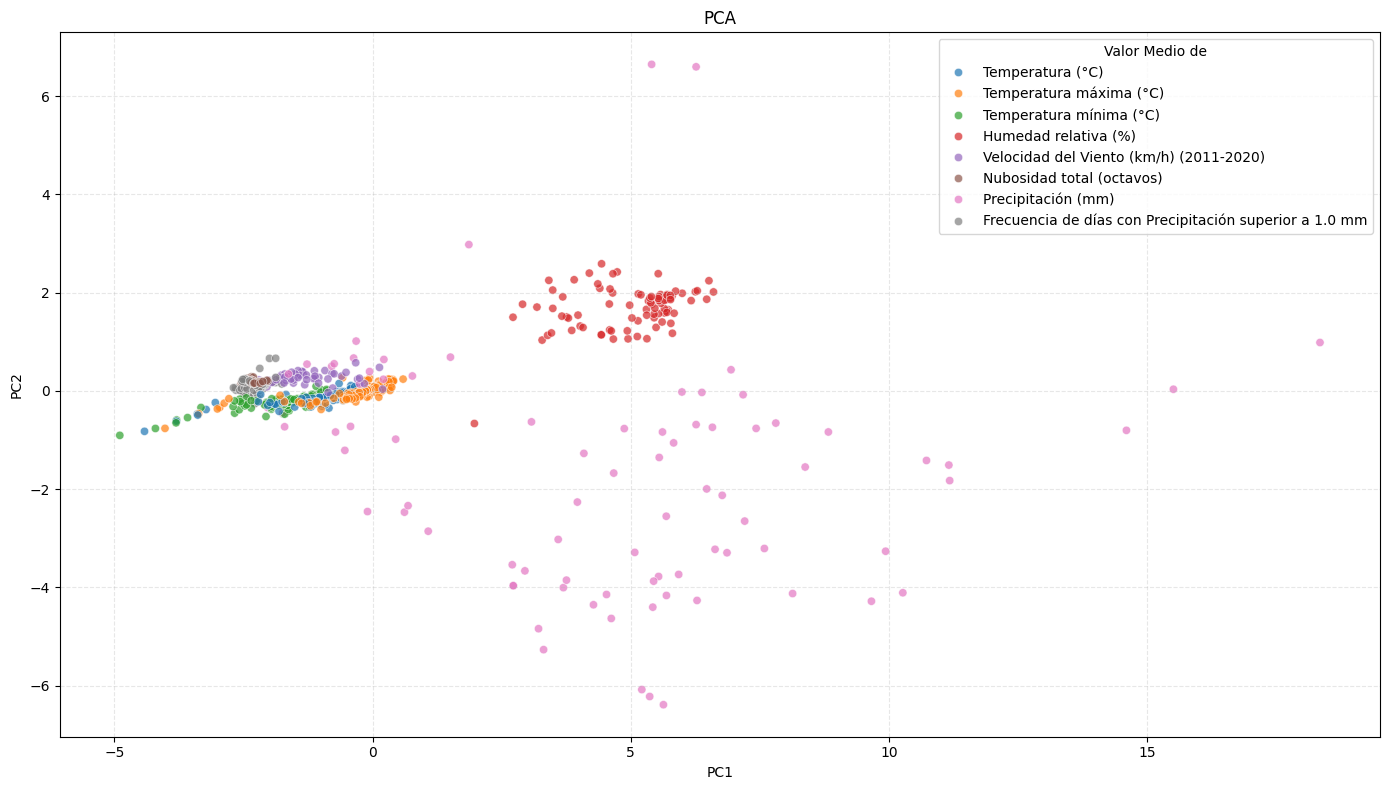

In [38]:
plt.figure(figsize=(14,8))
sns.scatterplot(data=df_components, x='PC1', y='PC2', hue='Valor Medio de', alpha=0.7)
plt.title('PCA')
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


In [39]:
# varianza explicada por cada componente
explained_var = pca.explained_variance_ratio_
explained_var

array([0.85444734, 0.12128281])

In [40]:
# varianza acumulada
cumulative_var = np.cumsum(explained_var)
cumulative_var

array([0.85444734, 0.97573014])

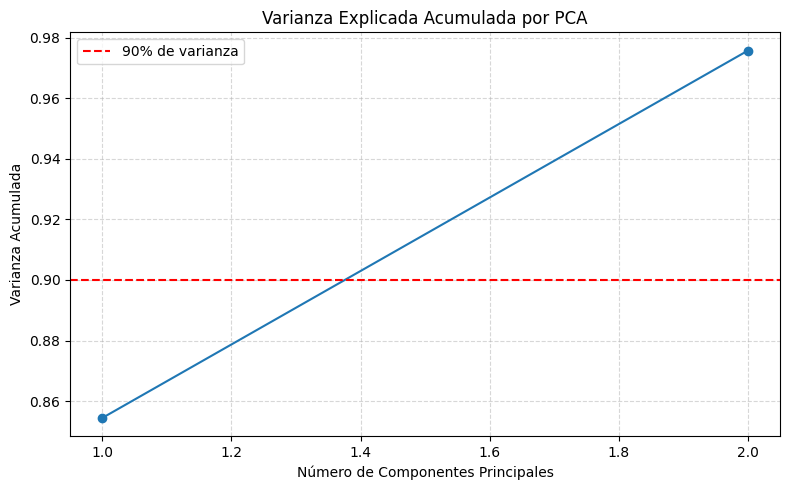

In [41]:
# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de varianza')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
# Pivotear para tener columnas por tipo de variable
df_pivot = df_30.pivot_table(
    index=['Estación', 'Mes'],
    columns='Valor Medio de',
    values='Valor'
).reset_index()

# Filtrar filas que tengan ambas variables (sin NaN)
df_filtered = df_pivot.dropna(subset=['Humedad relativa (%)', 'Precipitación (mm)'])


resultados = []

for estacion in df_filtered['Estación'].unique():
    sub_df = df_filtered[df_filtered['Estación'] == estacion]
    
    # Verificamos que haya más de 2 puntos válidos para correlación
    if len(sub_df) >= 2:
        r, p = pearsonr(sub_df['Humedad relativa (%)'], sub_df['Precipitación (mm)'])
        resultados.append({
            'Estación': estacion,
            'Pearson_r': r,
            'p_valor': p,
            'Significativa': p <= 0.05
        })

# Mostrar resultados
resultados_df = pd.DataFrame(resultados)
print(resultados_df.sort_values(by='Pearson_r', ascending=False))


C:\Users\Juan\AppData\Local\Temp\ipykernel_5144\3815679465.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df_30.pivot_table(


                   Estación  Pearson_r   p_valor  Significativa
23              ESQUEL AERO   0.948235  0.000003           True
3            BARILOCHE AERO   0.944079  0.000004           True
35   LA QUIACA OBSERVATORIO   0.886832  0.000121           True
19          EL BOLSÓN AERO*   0.862208  0.000309           True
11  COMODORO RIVADAVIA AERO   0.776473  0.002978           True
..                      ...        ...       ...            ...
73              SAN MIGUEL*  -0.666255  0.025194           True
28        GUALEGUAYCHÚ AERO  -0.686236  0.013727           True
55               PIGÜÉ AERO  -0.693073  0.012455           True
2         BAHÍA BLANCA AERO  -0.709532  0.009752           True
0           AEROPARQUE AERO  -0.724674  0.007675           True

[90 rows x 4 columns]


In [43]:
for estacion in df_filtered['Estación'].unique():
    sub_df = df_filtered[df_filtered['Estación'] == estacion]
    if len(sub_df) >= 2:
        r, p = pearsonr(sub_df['Humedad relativa (%)'], sub_df['Precipitación (mm)'])
        conclusion = (
            "Rechazamos H₀: relación significativa." if p <= 0.05
            else "No rechazamos H₀: sin relación significativa."
        )
        print(f"{estacion} → r={r:.2f}, p={p:.4f} → {conclusion}")


AEROPARQUE AERO → r=-0.72, p=0.0077 → Rechazamos H₀: relación significativa.
AZUL AERO* → r=-0.52, p=0.0840 → No rechazamos H₀: sin relación significativa.
BAHÍA BLANCA AERO → r=-0.71, p=0.0098 → Rechazamos H₀: relación significativa.
BARILOCHE AERO → r=0.94, p=0.0000 → Rechazamos H₀: relación significativa.
BERNARDO DE IRIGOYEN AERO → r=0.36, p=0.2436 → No rechazamos H₀: sin relación significativa.
BOLÍVAR AERO → r=-0.50, p=0.0998 → No rechazamos H₀: sin relación significativa.
BUENOS AIRES OBSERVATORIO → r=-0.60, p=0.0391 → Rechazamos H₀: relación significativa.
CATAMARCA AERO → r=0.08, p=0.7990 → No rechazamos H₀: sin relación significativa.
CERES AERO → r=-0.07, p=0.8194 → No rechazamos H₀: sin relación significativa.
CHAMICAL AERO → r=0.03, p=0.9210 → No rechazamos H₀: sin relación significativa.
CHILECITO AERO → r=0.09, p=0.8595 → No rechazamos H₀: sin relación significativa.
COMODORO RIVADAVIA AERO → r=0.78, p=0.0030 → Rechazamos H₀: relación significativa.
CONCORDIA AERO → r=-0

#### 🎯 Pregunta del test

¿Existe una relación monótona significativa entre la **humedad relativa mensual** y la **precipitación mensual** en cada estación meteorológica?

---

#### 🧪 Hipótesis estadística

Para cada estación:

- **Hipótesis nula (H₀):**  
  No existe una correlación monótona significativa entre la humedad relativa (%) y la precipitación (mm) mensual.  
  \[
  $\rho_s = 0$
  \]

- **Hipótesis alternativa (H₁):**  
  Existe una correlación monótona significativa entre la humedad relativa (%) y la precipitación (mm) mensual.  
  \[
  $\rho_s$ $\neq 0$
  \]

---

#### ✅ Criterio de decisión

- Si el **p-valor ≤ 0.05**, **rechazamos H₀**: hay evidencia suficiente para afirmar que existe una relación significativa.
- Si el **p-valor > 0.05**, **no rechazamos H₀**: no hay evidencia suficiente de relación.

---

#### 📊 Prueba estadística utilizada

**Coeficiente de correlación de Spearman (ρ)**  
Este coeficiente mide la relación monótona entre dos variables continuas, sin requerir que la relación sea lineal ni que las variables sigan una distribución normal.


In [ ]:


for estacion in df_filtered['Estación'].unique():
    sub_df = df_filtered[df_filtered['Estación'] == estacion]
    
    if len(sub_df) >= 2:
        r, p = spearmanr(sub_df['Humedad relativa (%)'], sub_df['Precipitación (mm)'])
        conclusion = (
            "✅ Rechazamos H₀: relación significativa." if p <= 0.05
            else "🟡 No rechazamos H₀: sin relación significativa."
        )
        print(f"{estacion:<30} → Spearman r = {r:.2f}, p = {p:.4f} → {conclusion}")


AEROPARQUE AERO                → Spearman r = -0.72, p = 0.0079 → ✅ Rechazamos H₀: relación significativa.
AZUL AERO*                     → Spearman r = -0.59, p = 0.0415 → ✅ Rechazamos H₀: relación significativa.
BAHÍA BLANCA AERO              → Spearman r = -0.62, p = 0.0332 → ✅ Rechazamos H₀: relación significativa.
BARILOCHE AERO                 → Spearman r = 0.98, p = 0.0000 → ✅ Rechazamos H₀: relación significativa.
BERNARDO DE IRIGOYEN AERO      → Spearman r = 0.06, p = 0.8629 → 🟡 No rechazamos H₀: sin relación significativa.
BOLÍVAR AERO                   → Spearman r = -0.43, p = 0.1667 → 🟡 No rechazamos H₀: sin relación significativa.
BUENOS AIRES OBSERVATORIO      → Spearman r = -0.58, p = 0.0479 → ✅ Rechazamos H₀: relación significativa.
CATAMARCA AERO                 → Spearman r = 0.15, p = 0.6331 → 🟡 No rechazamos H₀: sin relación significativa.
CERES AERO                     → Spearman r = 0.00, p = 1.0000 → 🟡 No rechazamos H₀: sin relación significativa.
CHAMICAL AERO